# Libraries

Import your libraries

In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import sklearn
import traceback
import string
import statistics as cal
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy import signal
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix, confusion_matrix

## load dataset
below we load dataset of player 15

in the last line we create an extra feature

In [4]:
## this is for testing the new system
df = df = pd.read_csv('player_15_balanced_rotations_Dataset.csv')


#df['frameRotationalSpeedZ'] = abs(df['frameRotationalSpeedZ'])
#df['FRSZDiff'] = np.insert(np.diff(df.frameRotationalSpeedZ,n=1)*12,0,0)
#df['wheelRotationalSpeedX'] = abs(df['wheelRotationalSpeedX'])
df['extra']= (df.wheelRotationalSpeedX-df.frameRotationalSpeedZ)




function for defining the best prediction parameters

found on the internet: this is not used in the final product


In [48]:

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [49]:
##calling the last function 
#----------------------------------------------------------------------------
final_iv, IV = data_vars(df,df['Action 180 rotation'])

IV.sort_values('IV')

#--------------------
#bron:
#https://sundarstyles89.medium.com/weight-of-evidence-and-information-value-using-python-6f05072e83eb

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_NAME            IV
1     Action 180 rotation  0.000000e+00
2      Action 90 rotation  9.927135e-07
5                   FRSY2  1.207318e-03
26  frameRotationalSpeedY  1.207318e-03
20                frRoAng  2.979417e-03
27  frameRotationalSpeedZ  3.028465e-03
22             frRoSpeed2  4.495248e-03
21              frRoSpeed  4.495248e-03
4                   FRSX2  4.988676e-03
25  frameRotationalSpeedX  4.988676e-03
8             Filt_WheelX  5.457146e-03
15                  frAcc  6.710701e-03
16                 frAcc2  6.710701e-03
7             Filt_FrameZ  7.525422e-03
11               WRSXDiff  8.927886e-03
14                  extra  1.058222e-02
0                  Action  1.112778e-02
12                  WRSY2  1.117814e-02
30  wheelRotationalSpeedY  1.117814e-02
6                FRSZDiff  1.149410e-02
29  wheelRotationalSpeedX  2.650024e-02
23                frSpeed  8.194720e-02
24               frSpeed2  8.194720e-02
9                 Quarter  9.560113e-02
13                  WRSZ2  1.092704e-01
31  wheelRotationalSpeedZ  1.092704e-01
18                frRoAcc  1.344989e-01
19               frRoAcc2  1.344989e-01
28               timeLine  1.364090e-01
10             Unnamed: 0  1.364123e-01
17                frDispl  1.364156e-01
3         Action rotation  6.904776e+00

# Preparing Data

We made a function to load in the data and split it into chunks. 
Chunksize and overlap can be defined within this function. 
We have a few if statements wich can create different features in the chunks. 
For each feature we can define if it needs to be the mean value of each second or if it need to be the max value of each second. 



In [2]:
def Dataloader(CsvFile, ChunkSize, ChunkOverlap, OperationList):
#CsvFile = put in the filename(as string) example : matrix_player_15_game_2_quartersplit.csv
#ChunkSize = put in the size you want the chunks to be (in seconds) example: 1
#ChunkOverlap = the size you want the chunks to overlap (in seconds) example: 0.5
#Operationlist = input dataframe of names with operations that u want to make changes to. example:
                                #Operationlist = pd.DataFrame({'frAcc':['cal.mean'], 'wheelRotationalSpeedX':['cal.mea']})


#load in csv file
    df = pd.read_csv(CsvFile)

    chunks = [df[i:i+ChunkSize] for i in range(0,df.shape[0],ChunkOverlap)]

    frames = []

    #for chunk in chunks:
        #chunk = chunk.drop(columns=['Unnamed: 0'])
        #frames.append(chunk)

        
    df_end =[]
    
    for frame in chunks: 
        result = [] #Reset the result array
        for column in list(df.columns):
        
            if column in OperationList: #Check if column is in namelist
            
                if OperationList[str(column)].values == 'cal.mean': #You can at more function if you want
                    X = cal.mean(frame[str(column)].tolist()) #Calculate mean of all columns named in namelist with operation cal.mean
                    
                elif OperationList[str(column)].values == 'round':
                        X = round(cal.mean(frame[str(column)].tolist()))
                        
                else: #If the given operations isn't cal.mean
                        frame[str(column)] = [abs(ele) for ele in frame[str(column)]] #Get absolute value of all elements in list
                        X = max(frame[str(column)].tolist()) #Get single max value from list 
            else:
                frame[str(column)] = [abs(ele) for ele in frame[str(column)]] #Get absolute value of all elements in list
                X = max(frame[str(column)].tolist()) #Get single max value from list
            
            
            result.append(X) #Append results to list
        
        df_end.append(result) #Append all results into one big list
    
    df_end = pd.DataFrame(df_end, columns = list(df.columns)) #Convert list to df
    return(df_end)
    
def lpfilter(cutoff_freq,var1,sampling_freq):
    Order = 5
    sampling_duration = len(var1)/5

    normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
    numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)
    filtered_var1 = signal.lfilter(numerator_coeffs, denominator_coeffs, var1)
    
    return filtered_var1

create list of feature needs. 

activate dataloader by calling the dataset. 

In [151]:
OperationList = pd.DataFrame({'Action' : ['round'], 'frameRotationalSpeedZ':['cal.mean']})
#df = Dataloader('Player_15_Game2_Sprints_Q124_V2-Copy1.csv',100,50, OperationList)
#print(Dataloader('matrix_Player_15_game_2_QuarterSplit.csv', 100, 50, OperationList))
df = pd.read_csv('Player_15_Game2_Sprints_Q124_V2-Copy1.csv')


In [23]:
pt = pd.read_csv('player_15_balanced_rotations_Training&Testset.csv')
print(pt)
pt = [pt[i:i+100] for i in range(0,pt.shape[0],50)]
prt2 =[]
for frame in pt: 
    prt2.append(max(frame['frameRotationalSpeedZ'].tolist()))
    
print(len(prt2))

        Unnamed: 0     frAcc  frRoAcc  frDispl  frRoAng  frSpeed  timeLine  \
0                0  17.91200   2828.7  3394.90   81.515  0.23278    3581.0   
1                1   7.14760   2828.7  3395.70   81.397  0.41190    3581.0   
2                2  -0.89061   2828.8  3396.50   82.233  0.48338    3581.0   
3                3   4.17050   2828.8  3397.30   74.342  0.47447    3581.0   
4                4   1.15710   2828.8  3398.00   74.332  0.51618    3581.0   
...            ...       ...      ...      ...      ...      ...       ...   
527346      527346  11.32900   6087.3  -505.60 -196.930  0.13920    7722.9   
527347      527347   5.47300   6087.3  -507.52 -187.620  0.25250    7722.9   
527348      527348  -0.63028   6087.3  -509.35 -179.280  0.30723    7722.9   
527349      527349   2.68860   6087.3  -511.14 -177.520  0.30092    7722.9   
527350      527350  -1.92170   6087.3  -512.93 -180.650  0.32781    7722.9   

        frameRotationalSpeedX  frameRotationalSpeedY  frameRota

In [ ]:
df.columns

## data preperation 

below their are some multiplications to set features around the same values. 
for classification this is not neceserry but we still want to switch to regression function. 

also we created lists called column to switch between features for the model quickly. 
we created training and testing splits by calling the different quarters in a match. 3/4 for training 1/4 for testing. 

these column can be easaly called upon when creating training data. 

In [152]:
# getting the parameters more ready these parameters all have some sort of the same output

df['frAcc2'] = df.frAcc*10   #influences the sprint
df['frRoAcc2'] = df.frRoAcc   #the rotational things is something to work on
df['frSpeed2'] = df.frSpeed*100     # influences the speed

df['frSpeed3'] = lpfilter(0.2,(df.frSpeed2*0.3),5)

df['FRSX2'] = df.frameRotationalSpeedX*10      #influenced by fast offence or fast defence
df['FRSY2'] = df.frameRotationalSpeedY*10      #influenced by speed&Rot
df['WRSZ2'] = df.wheelRotationalSpeedZ*5      #variable for sprint
df['WRSY2'] = df.wheelRotationalSpeedY*3      #variable for rotations

df['WRSXDiff'] = np.insert(np.diff(df.wheelRotationalSpeedX,n=1)*12,0,0)
df['FRSZDiff'] = np.insert(np.diff(df.frameRotationalSpeedZ,n=1)*12,0,0)#variable for rotations
df['stilltesting']= (df.WRSXDiff+df.FRSZDiff)
df['extra']= (df.wheelRotationalSpeedX+df.frameRotationalSpeedZ)
df['MeanfrRoSpZ'] = cal.mean(df.frameRotationalSpeedZ)
df['MeanwhRoSpX'] = cal.mean(df.wheelRotationalSpeedX)
df['pop'] = df.Filt_FrameZ-df['frameRotationalSpeedZ']
df['Acc'] = df.Filt_WheelX-df['wheelRotationalSpeedX']


train = df[df.Quarter!=2]
test = df[df.Quarter ==2]


column = ['frRoSpeed2','frDispl','Filt_WheelX','frameRotationalSpeedZ','WRSY2',]
column2 = ['frAcc2', 'extra','frSpeed2','wheelRotationalSpeedX']
column3 = ['frRoAng', 'frRoSpeed2', 'frameRotationalSpeedZ', 'wheelRotationalSpeedZ']
column4 = ['frSpeed','stilltesting']

X_train = train[column4]

y_train = train['Action'].to_numpy()

X_test = test[column4]

y_test = test['Action'].to_numpy()


df.to_csv('player_15_balanced_rotations_Training&Testset_to_chunks.csv')
#print(df['MeanfrRoSpZ'])      printing new values to see if they make sense
#print(df['frameRotationalSpeedZ'])    printing new values to see if they mae sense 


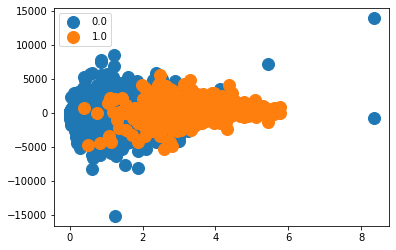

In [153]:
groups = df.groupby('Action')
for name,group in groups:
    plt.plot(group.frSpeed , group.stilltesting , marker='o', linestyle = '', markersize = 12 , label = name)
plt.legend()

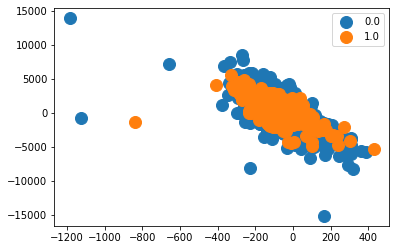

In [172]:
groups = df.groupby('Action')
for name,group in groups:
    plt.plot(group.Acc , group.stilltesting , marker='o', linestyle = '', markersize = 12 , label = name)
plt.legend()    



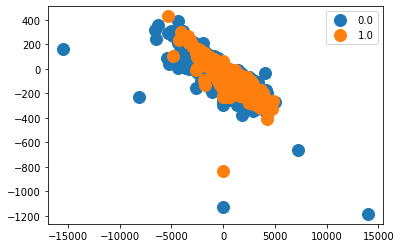

In [181]:
for name,group in groups:
    plt.plot(group.WRSXDiff, group.Acc , marker='o', linestyle = '', markersize = 12 , label = name)
plt.legend() 

## importance function 

below the training data gets called to calculate the feature importance. 


In [156]:

#model3 = RandomForestClassifier(n_estimators=350 ,max_depth=40 ,class_weight= 'balanced',min_samples_leaf=2,bootstrap=True,n_jobs=10)
#model3.fit(X_train,y_train)

clf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='entropy',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
            oob_score=False, random_state=42, verbose=0,
            warm_start=False)
clf.fit(X_train,y_train)


import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

frSpeed         0.845679
stilltesting    0.154321
dtype: float64

# Gridsearch toepassen


In [228]:

tree_model_2 =  RandomForestClassifier(class_weight='balanced', random_state = 42,n_jobs = 10)


param_grid_model_2 = {'n_estimators': [80,100,200,400,800],'min_samples_leaf':[2,3,4,5,6,7],'criterion':['gini','entropy'], 'max_depth':[5,7,9,11,14]} 



tree = GridSearchCV(tree_model_2,param_grid_model_2)
tree = tree.fit(X_train,y_train)
print(tree.best_params_)
#print(tree.best_score_)
#print("Test accuracy of best grid search hypers:", tree.score(X_test, y_test))

{'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 2, 'n_estimators': 80}


## Visualizing gridsearch answers

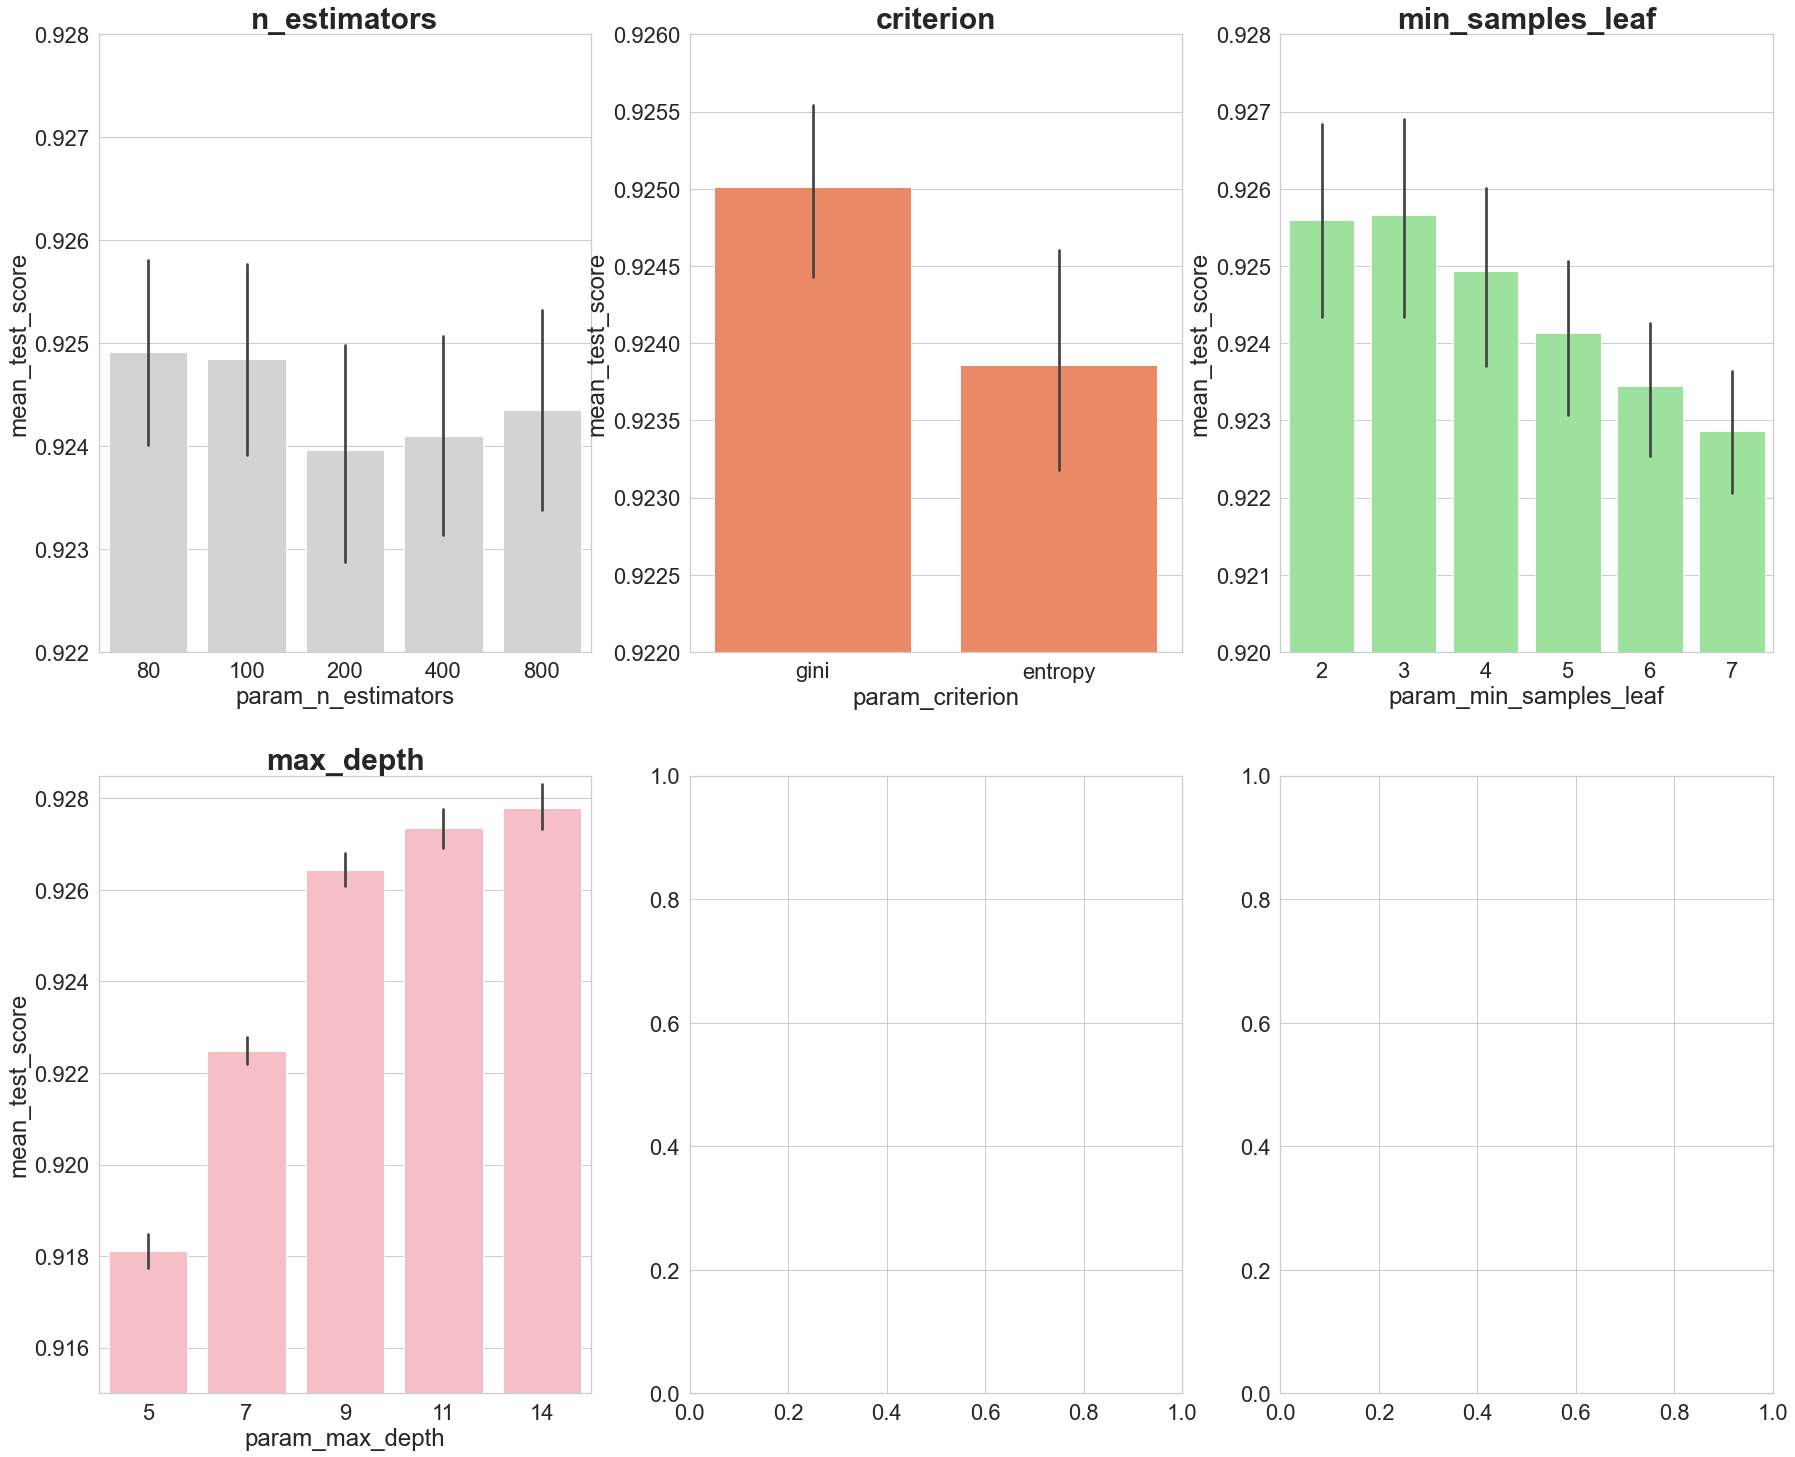

In [246]:
tree_df = pd.DataFrame(tree.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
tree_df = tree_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
tree_df.head(10)

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=tree_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.922,.928]) 
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_criterion', y='mean_test_score', data=tree_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.922,.926]) 
axs[0,1].set_title(label = 'criterion', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=tree_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.92,.928]) 
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=tree_df, ax=axs[1,0], color='lightpink')
axs[1,0].set_ylim([.915,.9285]) 
axs[1,0].set_title(label = 'max_depth', size=30, weight='bold')
#sns.barplot(x='param_max_features', y='mean_test_score', data=tree_df, ax=axs[1,1], color='wheat')
#axs[1,1].set_ylim([.88,.92]) 
#axs[1,1].set_title(label = 'max_features', size=30, weight='bold')
plt.show()

# Validate/Tune Model

Validate results of the model (Precision/Recall). Tune the parameters of the model to achieve better results

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


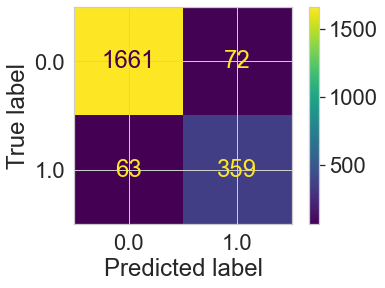

In [254]:
#model = RandomForestClassifier(class_weight= 'balanced',min_samples_leaf=2,n_jobs=10,random_state =42)
model = RandomForestClassifier(n_estimators=100 ,max_depth=12, max_features = 'auto' ,class_weight= 'balanced',min_samples_leaf=2,bootstrap=False,n_jobs=10,random_state =42)
model = RandomForestClassifier(class_weight= 'balanced', random_state=42,min_samples_leaf=3, max_depth =14, n_estimators =100)

model.fit(X_train,y_train)

plot_confusion_matrix(model,X_test, y_test)
plt.show()

TypeError: unhashable type: 'list'

# Export Data

Export the results in CSV format. Layout = Time,Action

In [124]:
X_test['Action'] = model.predict(X_test)

/tmp/ipykernel_7893/182367982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Action'] = model.predict(X_test)


In [66]:
#y_test = y_test.to_frame()
#y_test = y_test.sort_index()

In [125]:
X_test = X_test.sort_index()
False_pos = X_test[X_test['Action'] != y_test]
df_test = False_pos[(False_pos['Action'] == 1)]
df_test.index

df_test.to_csv()

',frSpeed,stilltesting,Action\n2636,2.3595,85.38303599999995,1\n2637,2.332,585.4745759999996,1\n2640,2.5379,374.9712599999996,1\n2641,2.5778,150.87985200000028,1\n2642,2.5778,402.2205,1\n2668,2.5138,1107.0172199999997,1\n2669,2.5138,1786.5528360000005,1\n2675,2.608,92.6822784,1\n2684,3.8167,-345.82141679999756,1\n2685,3.4603,-518.6710080000001,1\n2686,3.2195,-258.4113384000001,1\n2687,2.9671,-870.5989331999997,1\n2688,2.7133,-544.8910776000008,1\n2689,2.5014,312.84135720000006,1\n2702,2.3681,649.8215184,1\n2712,2.6867,1586.538144,1\n2713,2.7132,-241.95567599999947,1\n2714,2.7132,-743.525664,1\n2734,4.6678,297.172812,1\n2735,4.1188,-763.4264279999995,1\n2736,4.1188,281.1522,1\n2737,3.57,-1161.3325200000002,1\n2738,3.3632,-611.7499200000002,1\n2739,3.3418,147.9317999999999,1\n2740,3.0506,-994.0646399999998,1\n2741,3.0197,667.5538440000004,1\n2742,3.3648,263.86872527999935,1\n2743,3.3648,-44.82992676,1\n2744,3.1935,-648.4989892799993,1\n2745,3.0263,-149.65618164000006,1\n2746,2.9277,-161.

In [130]:
Sprint = []
for i in range(1,len(df_test['Action']),1):  #stappen van 2 
    #if df_test.index[i]-df_test.index[i-1] > 3:
        Sprint.append(df_test.index[i-1]*(10/100))
        
#Sprint = pd.DataFrame(Sprint,columns=['Time'])
#Sprint.to_numpy()
Sprint

[263.6,
 263.7,
 264.0,
 264.1,
 264.2,
 266.8,
 266.90000000000003,
 267.5,
 268.40000000000003,
 268.5,
 268.6,
 268.7,
 268.8,
 268.90000000000003,
 270.2,
 271.2,
 271.3,
 271.40000000000003,
 273.40000000000003,
 273.5,
 273.6,
 273.7,
 273.8,
 273.90000000000003,
 274.0,
 274.1,
 274.2,
 274.3,
 274.40000000000003,
 274.5,
 274.6,
 274.7,
 274.8,
 274.90000000000003,
 276.7,
 276.8,
 277.0,
 277.1,
 277.2,
 277.40000000000003,
 277.5,
 277.6,
 277.7,
 279.6,
 279.7,
 282.3,
 282.40000000000003,
 292.2,
 292.3,
 292.40000000000003,
 294.8,
 294.90000000000003,
 295.0,
 295.1,
 295.90000000000003,
 296.0,
 296.1,
 296.90000000000003,
 297.0,
 297.1,
 297.2,
 297.8,
 297.90000000000003,
 300.40000000000003,
 300.5,
 302.7,
 303.6,
 303.7,
 303.8,
 303.90000000000003,
 304.0,
 304.1,
 305.7,
 305.8,
 305.90000000000003,
 306.0,
 306.1,
 307.0,
 307.1,
 307.20000000000005,
 308.20000000000005,
 308.3,
 309.20000000000005,
 309.3,
 309.90000000000003,
 316.70000000000005,
 317.20000000

In [69]:
###Sprint.to_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_FoundSprints.csv')

In [131]:
def plotfaults(sprint, Data1, Data2, Time):

    start = int((sprint-4)*10)
    stop = int((sprint+4)*10)

    wheelspeed = Data1[start:stop]
    framerot = Data2[start:stop]

    Time = Time[start:stop]
    fig, ax = plt.subplots(1,1)
    ax.plot(Time,wheelspeed,'r', Time,framerot,'b')
    ax.set_title('rotation ='+str(sprint))

/tmp/ipykernel_7893/1210177710.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


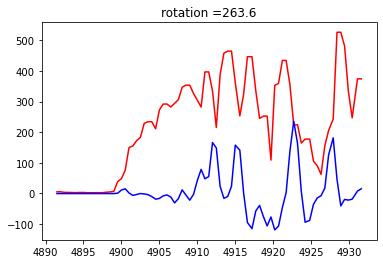

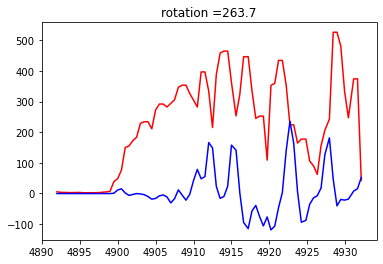

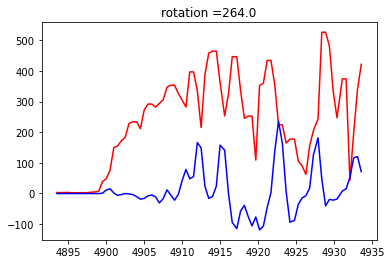

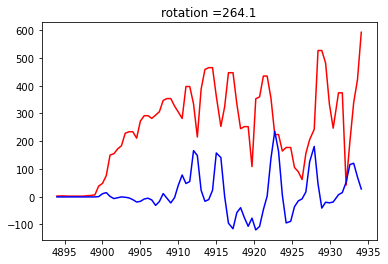

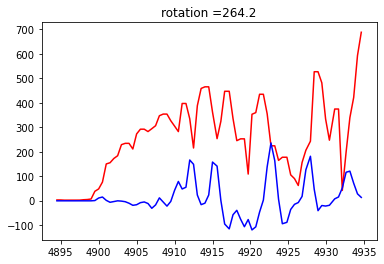

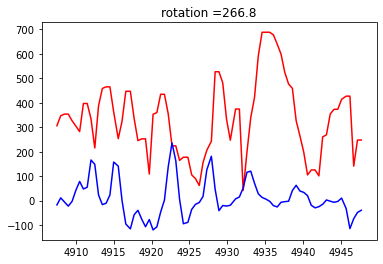

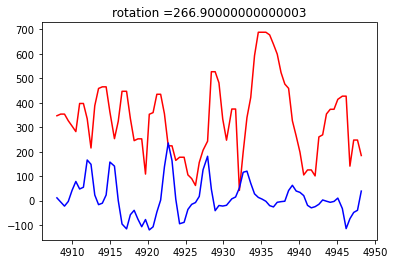

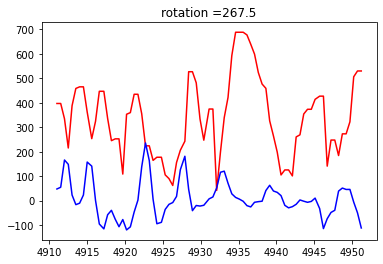

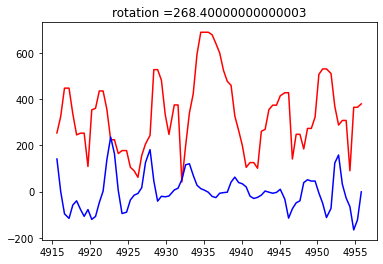

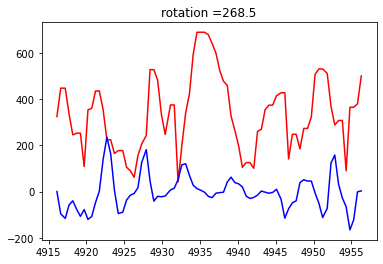

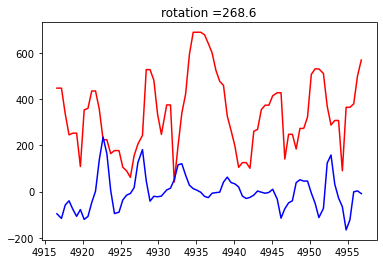

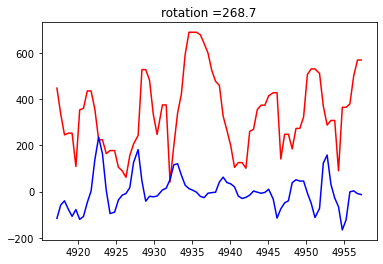

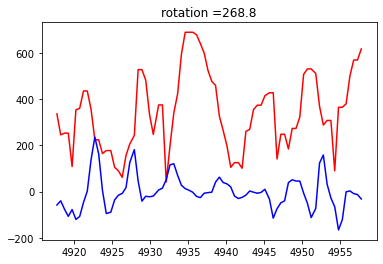

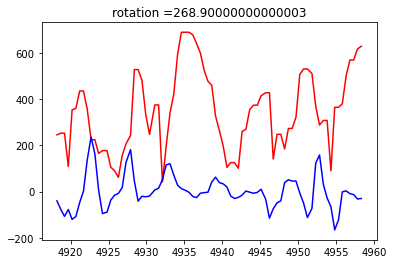

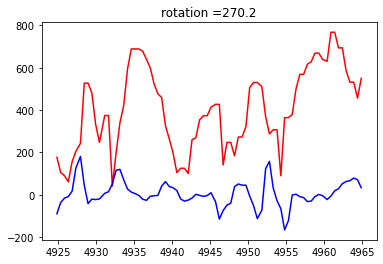

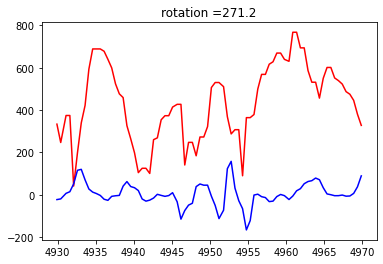

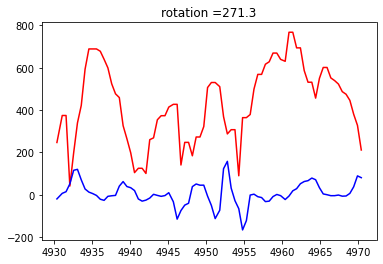

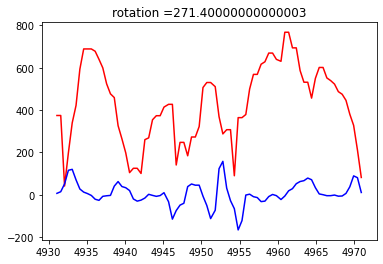

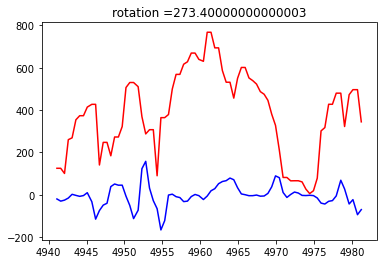

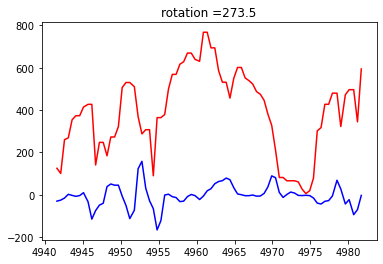

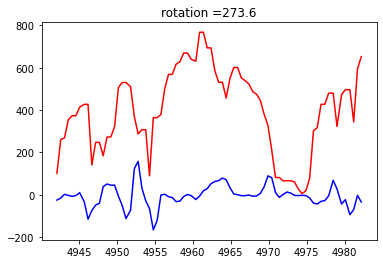

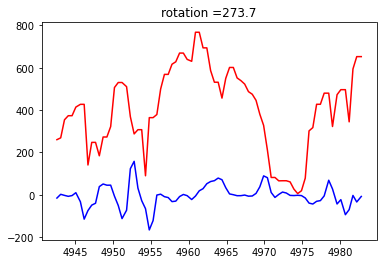

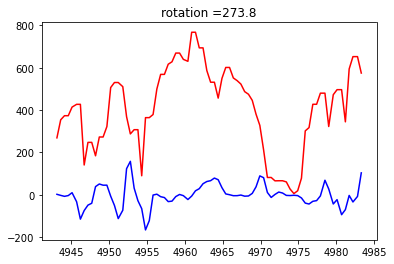

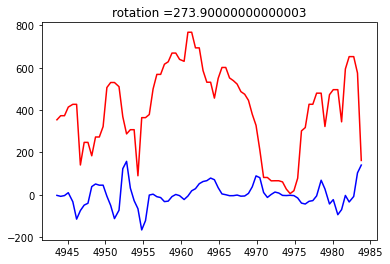

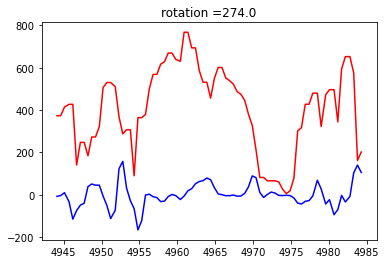

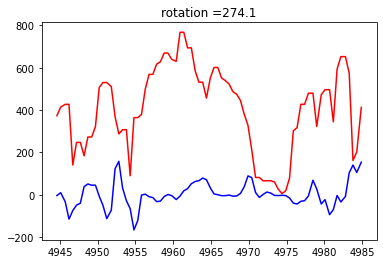

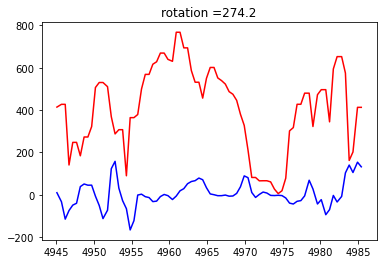

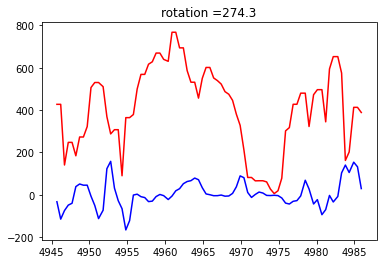

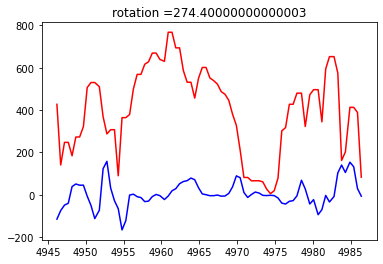

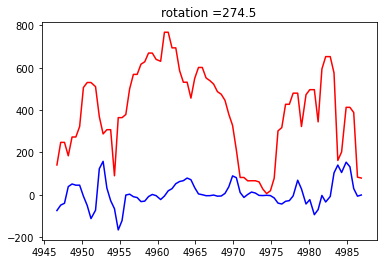

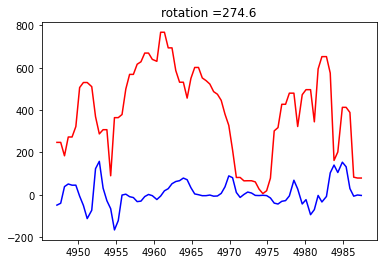

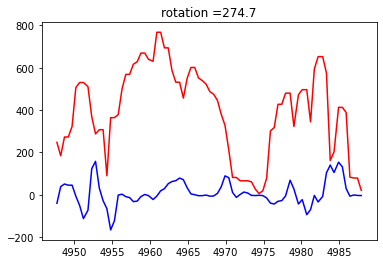

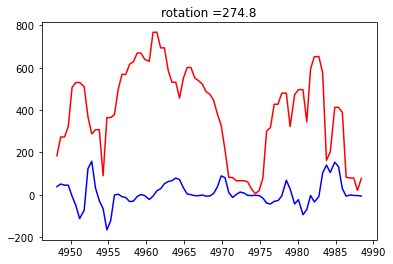

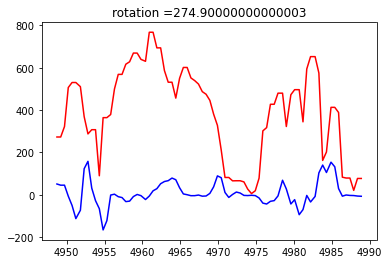

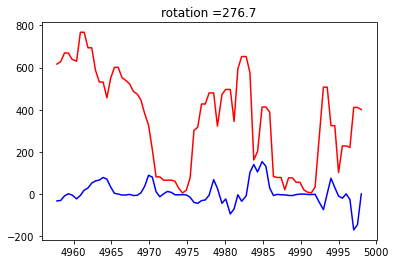

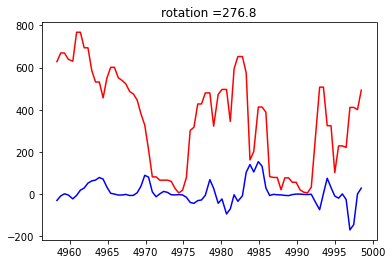

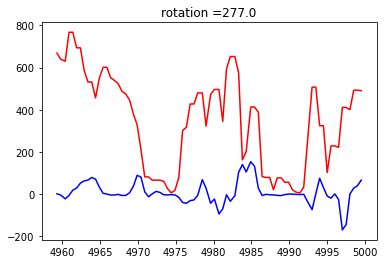

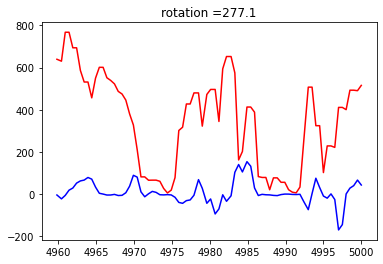

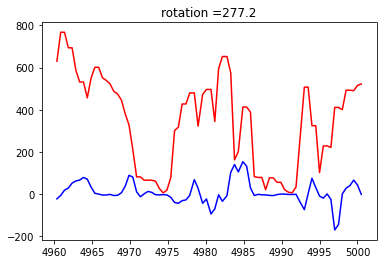

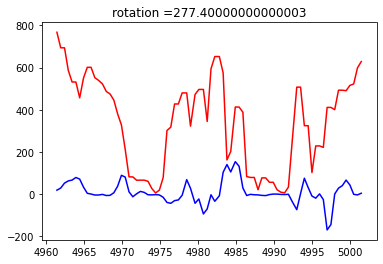

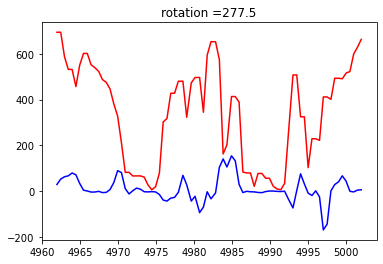

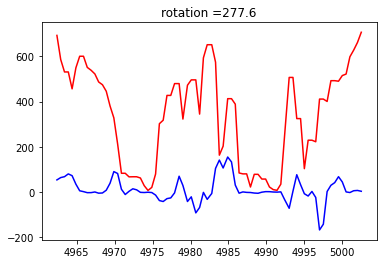

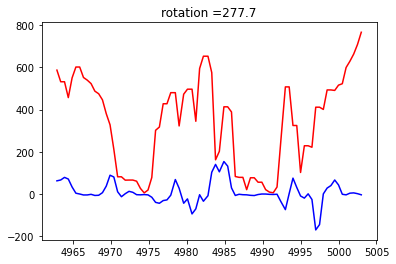

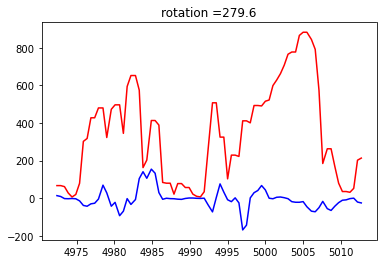

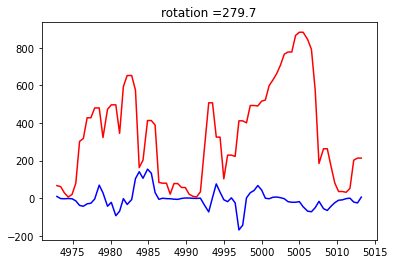

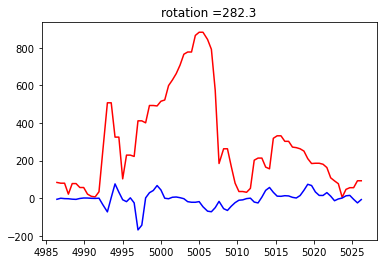

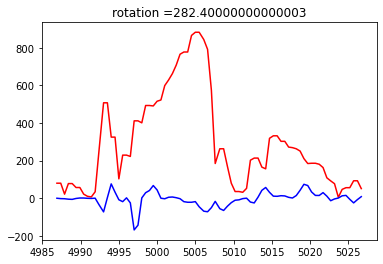

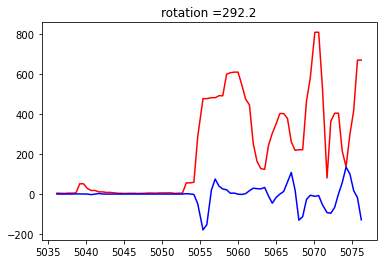

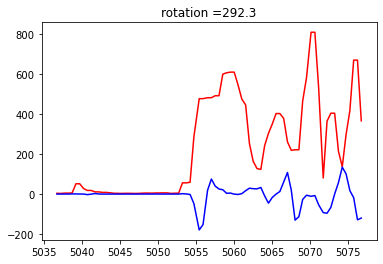

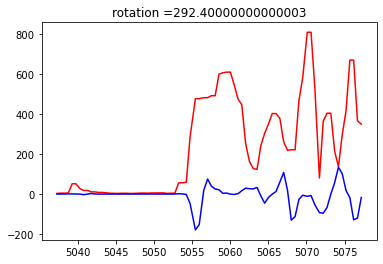

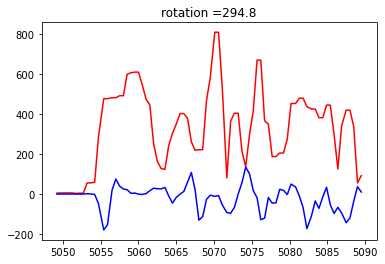

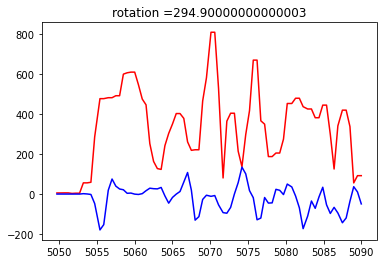

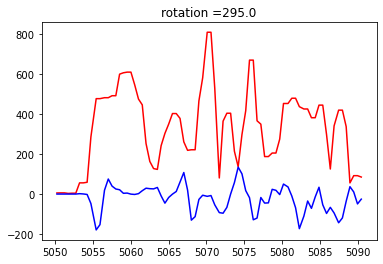

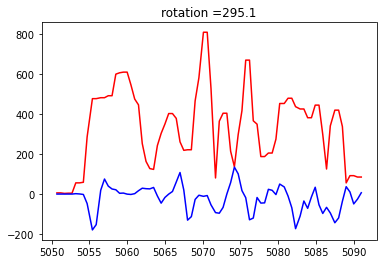

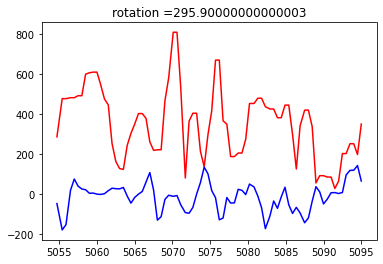

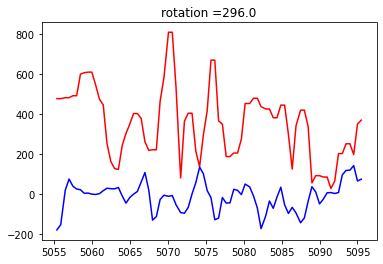

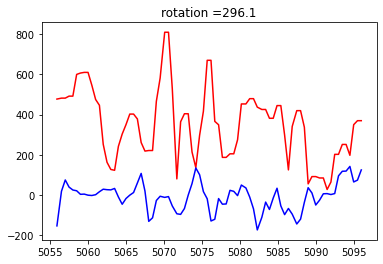

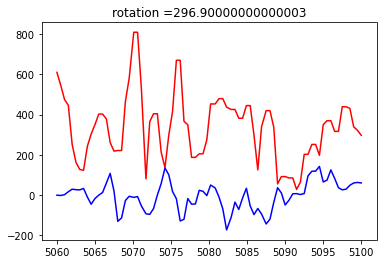

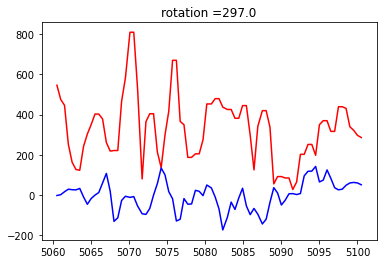

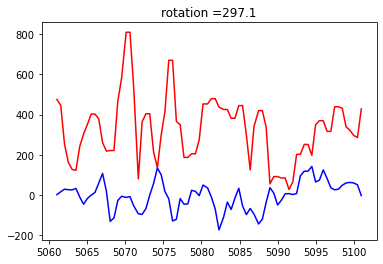

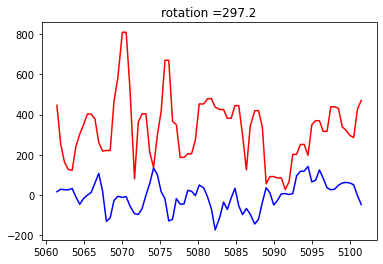

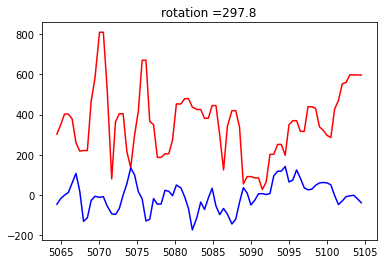

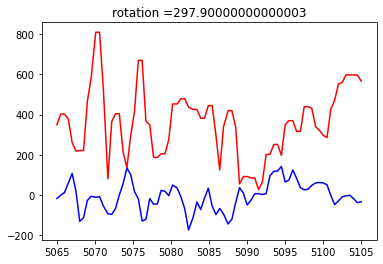

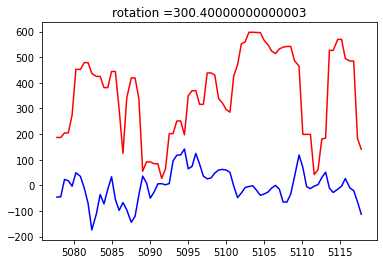

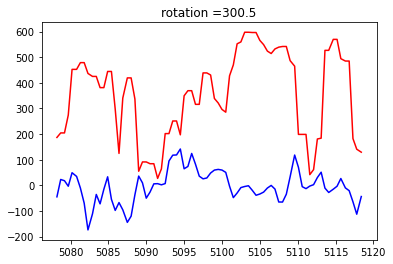

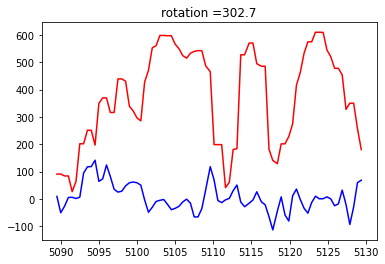

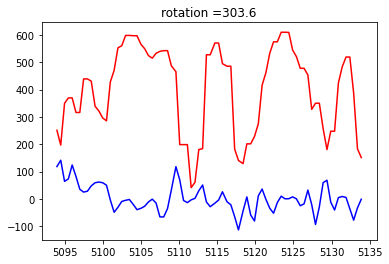

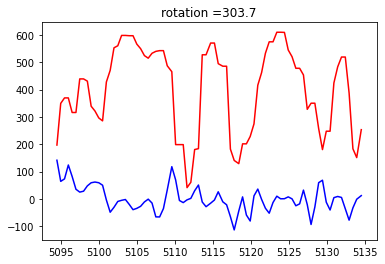

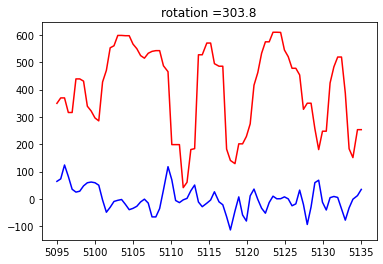

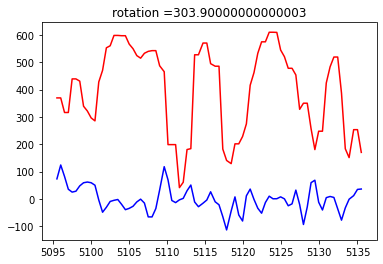

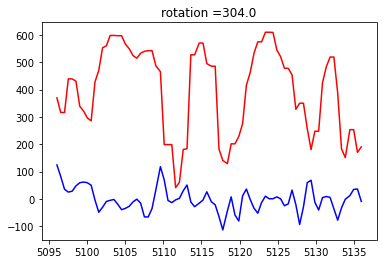

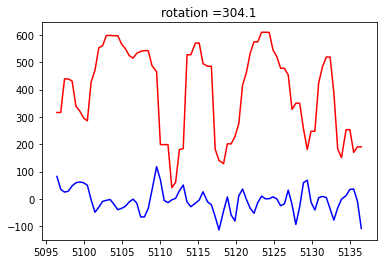

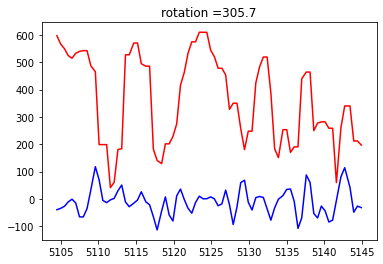

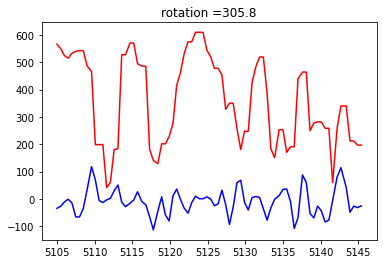

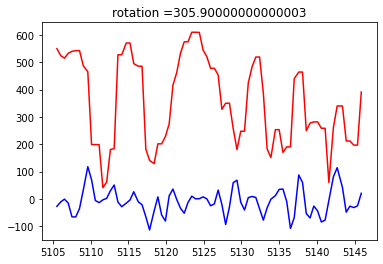

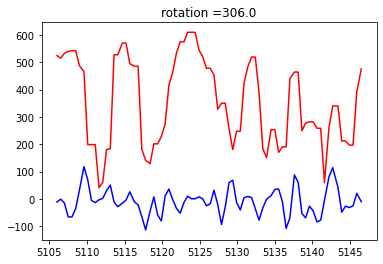

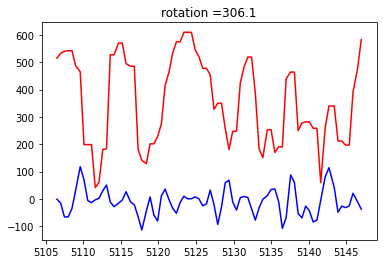

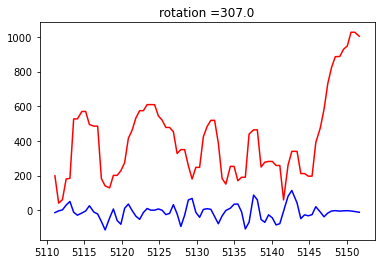

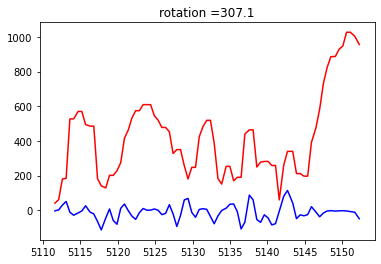

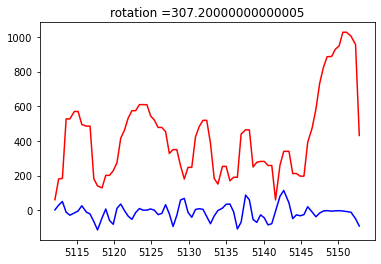

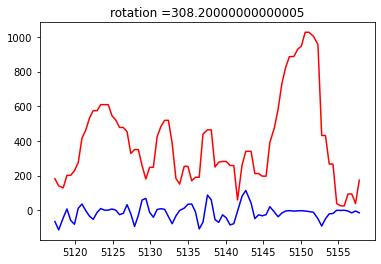

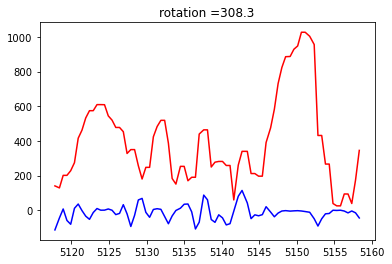

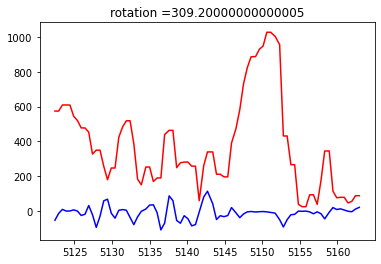

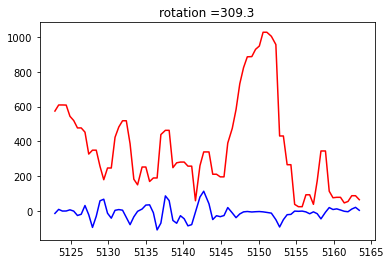

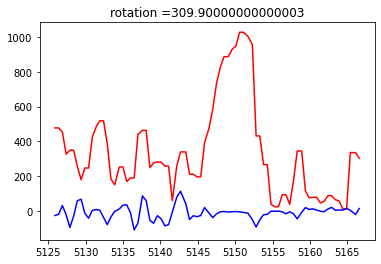

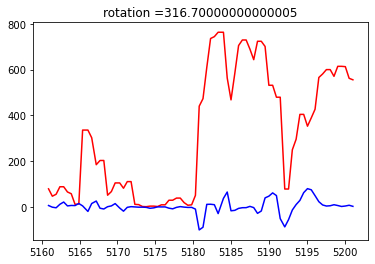

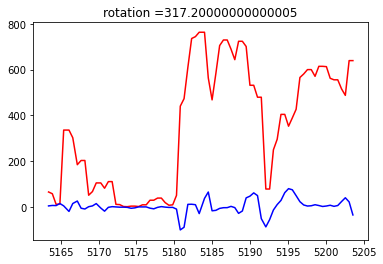

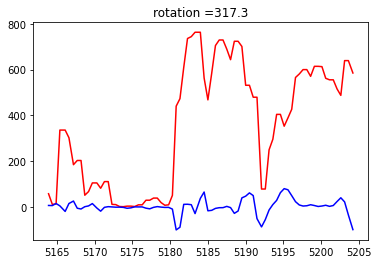

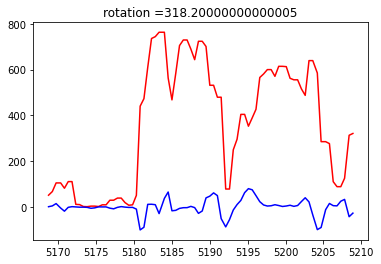

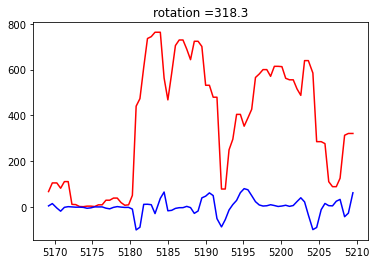

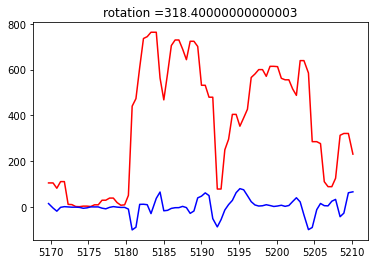

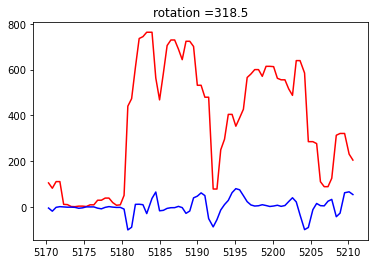

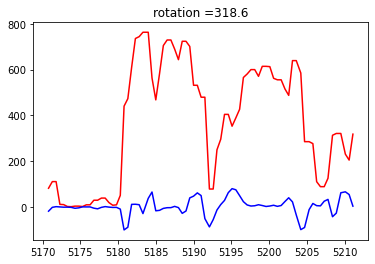

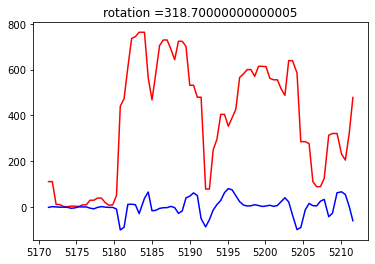

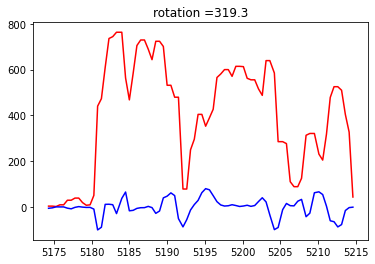

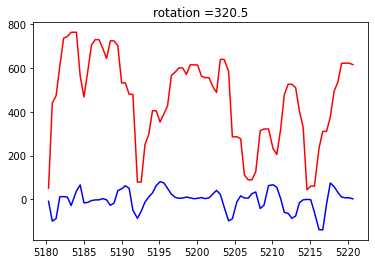

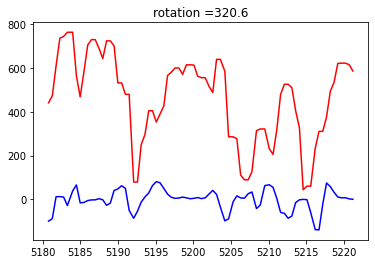

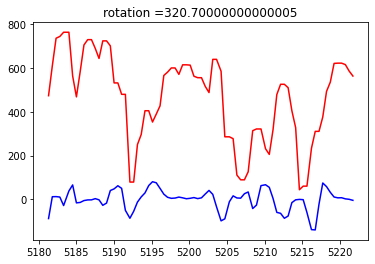

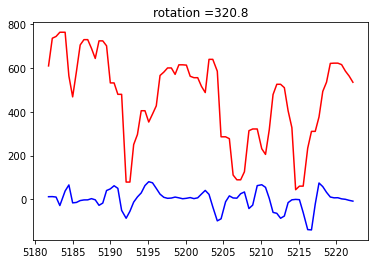

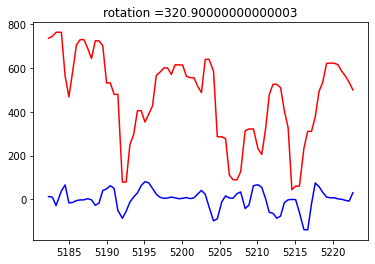

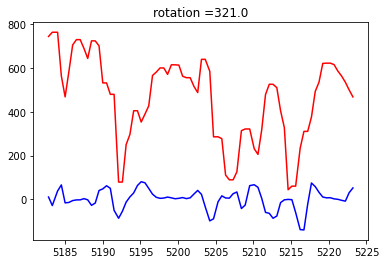

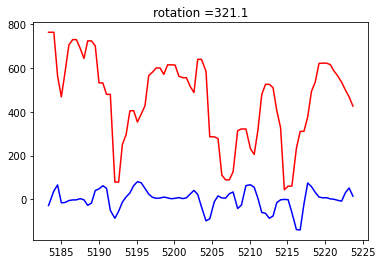

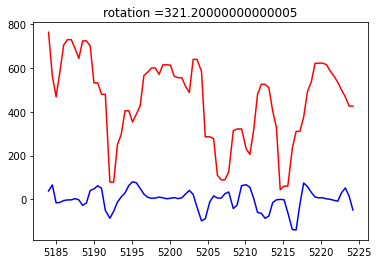

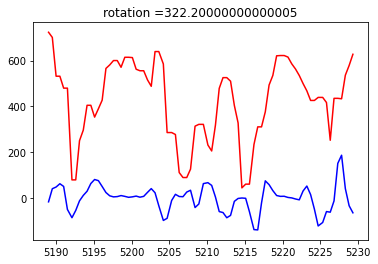

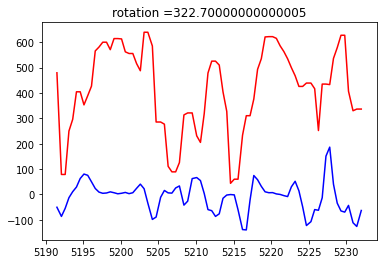

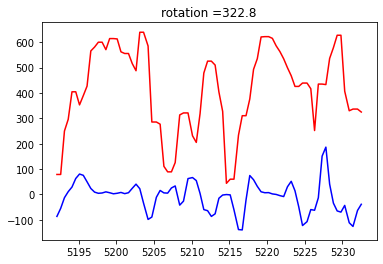

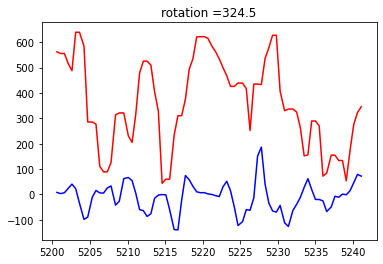

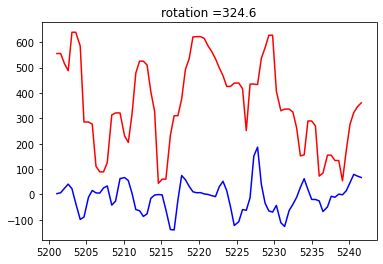

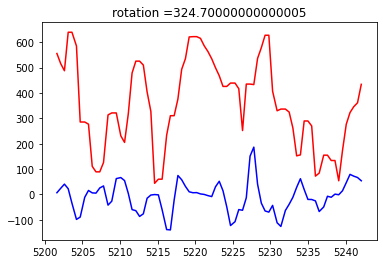

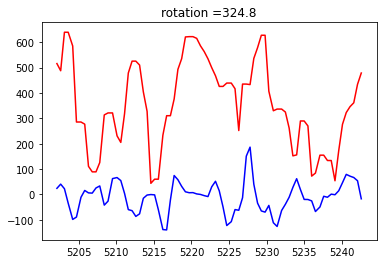

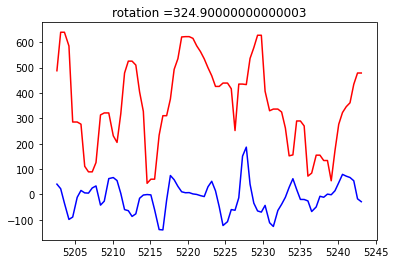

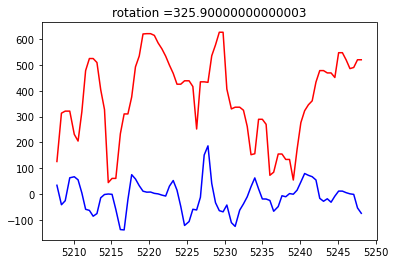

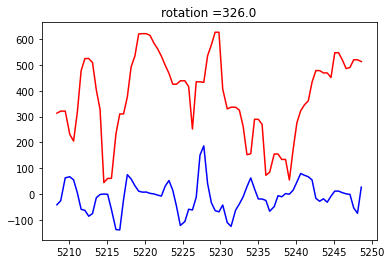

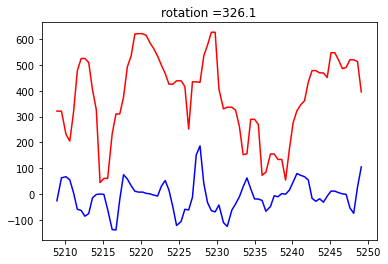

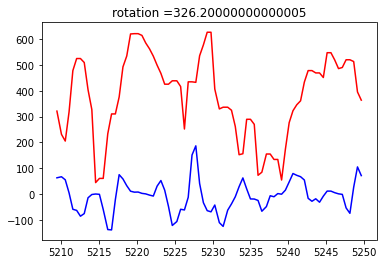

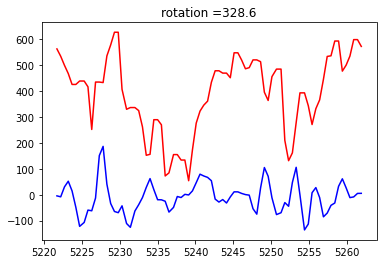

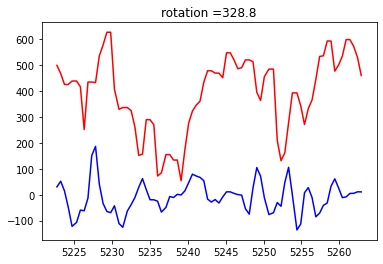

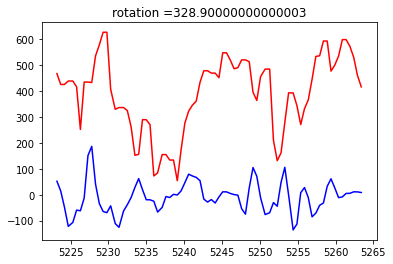

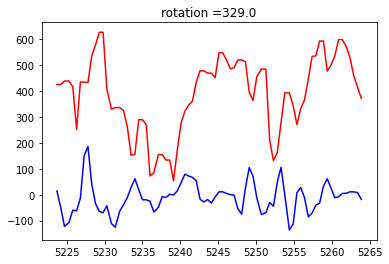

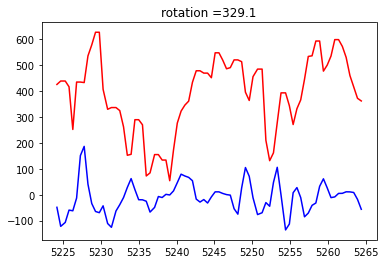

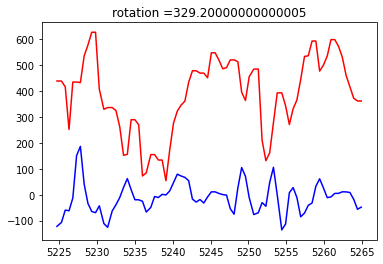

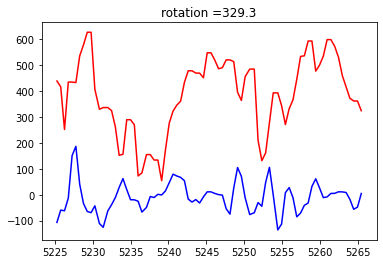

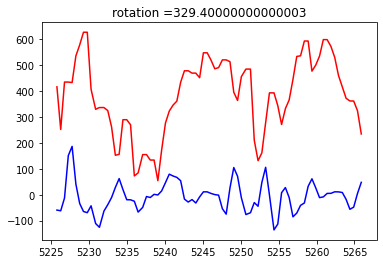

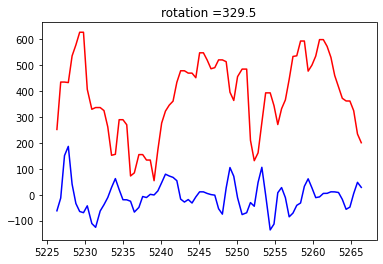

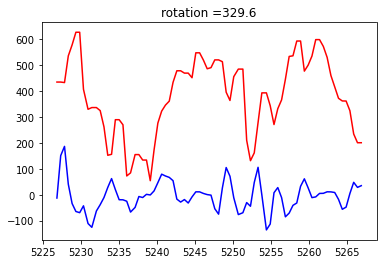

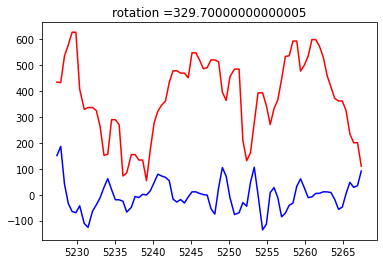

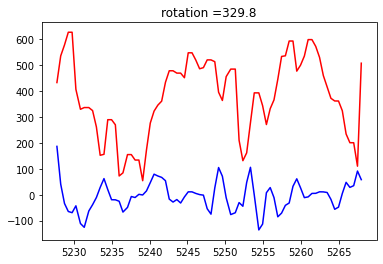

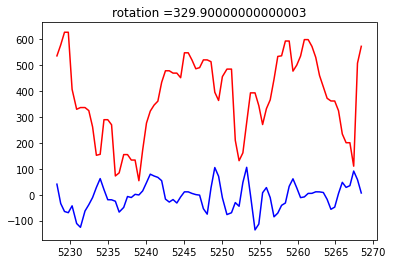

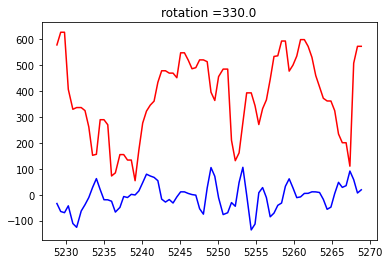

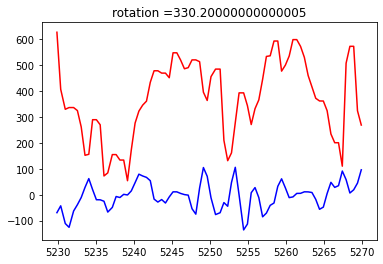

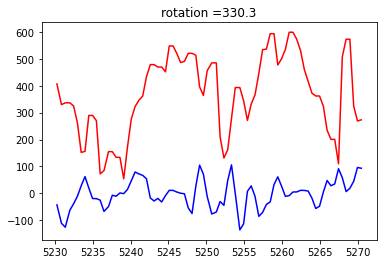

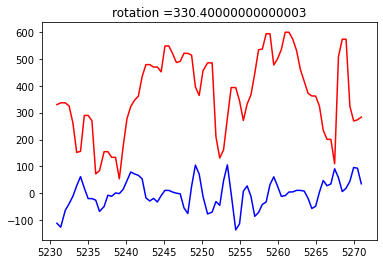

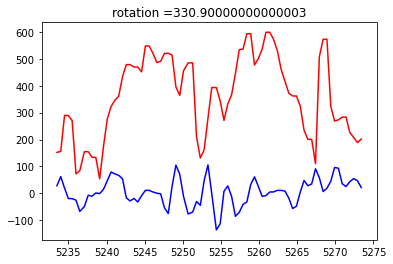

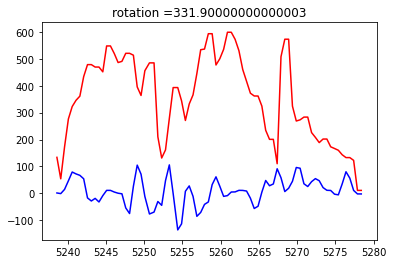

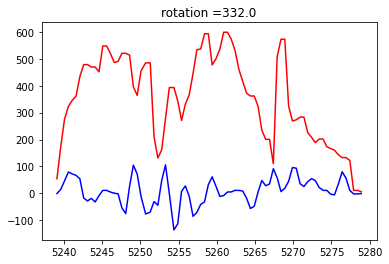

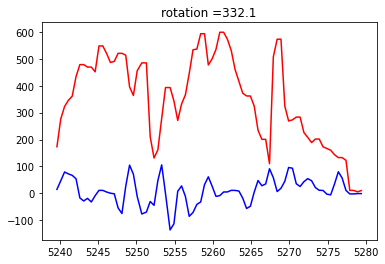

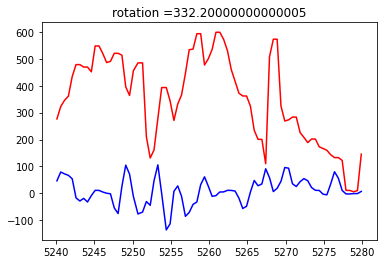

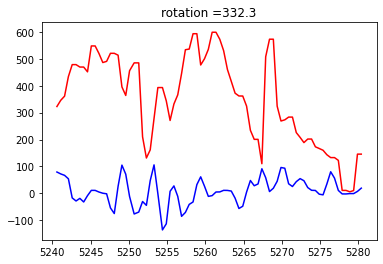

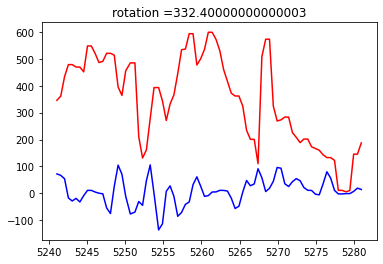

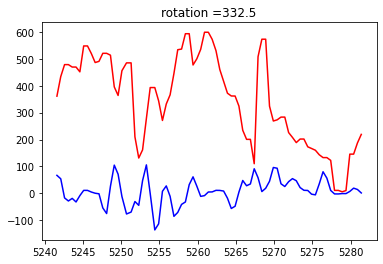

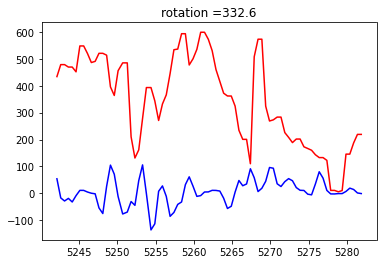

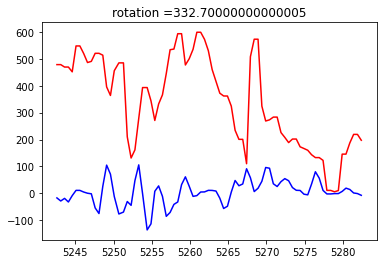

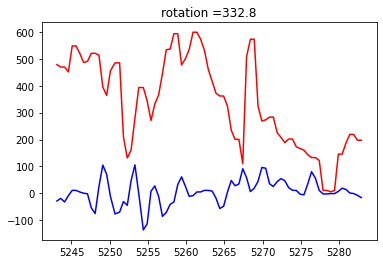

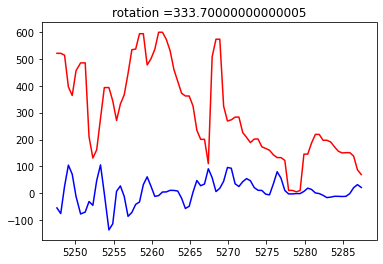

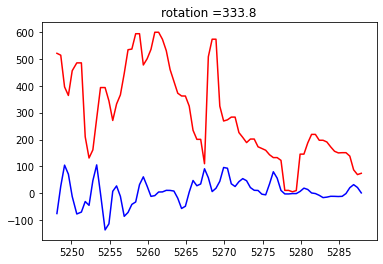

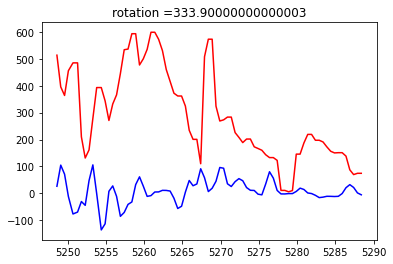

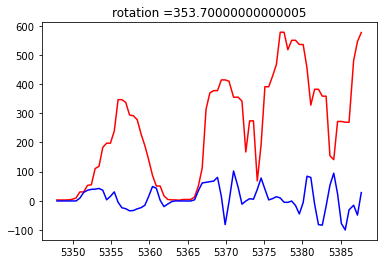

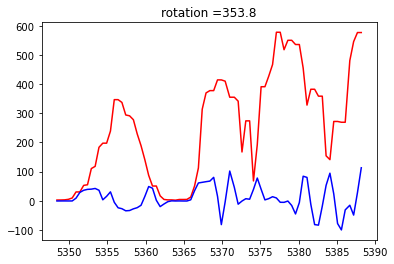

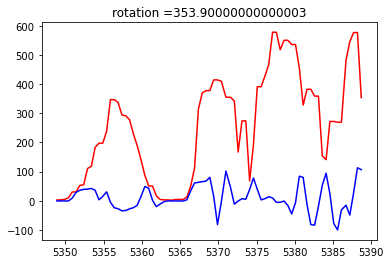

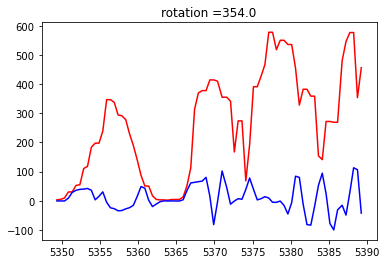

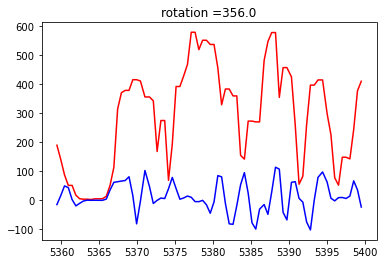

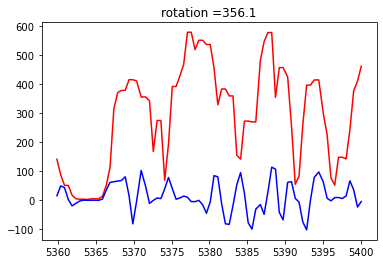

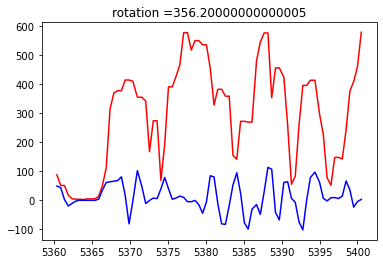

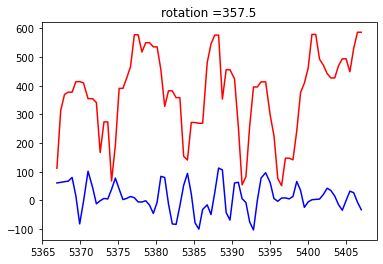

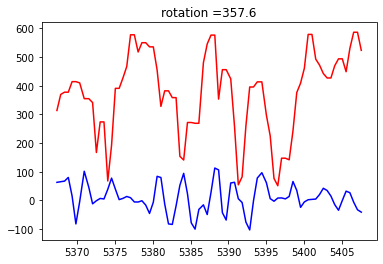

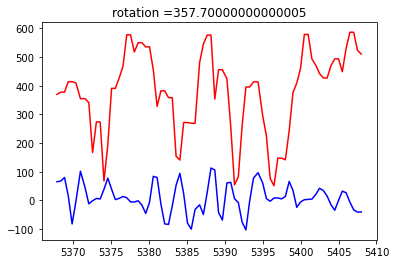

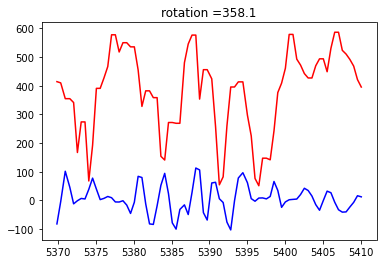

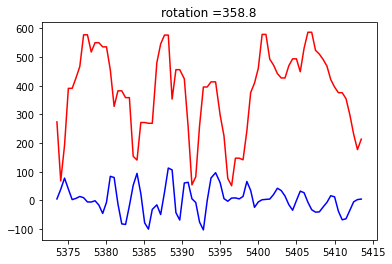

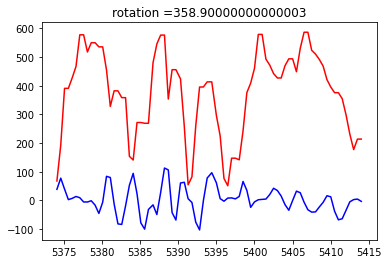

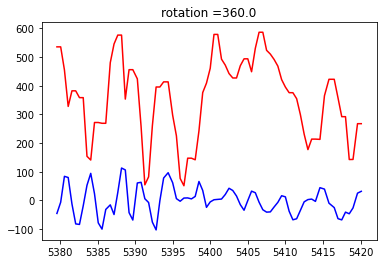

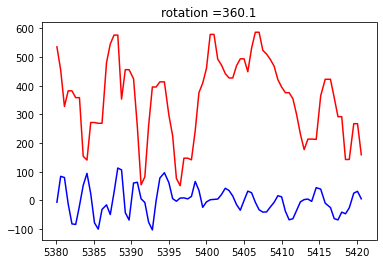

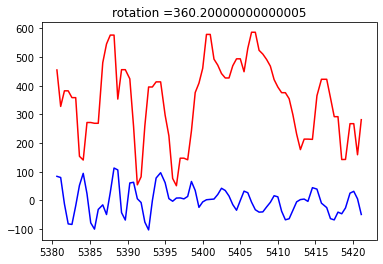

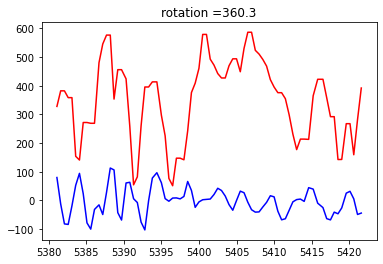

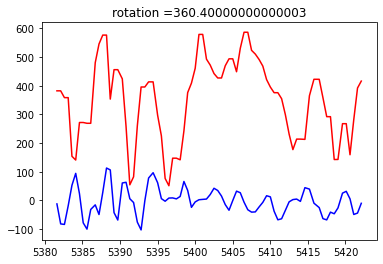

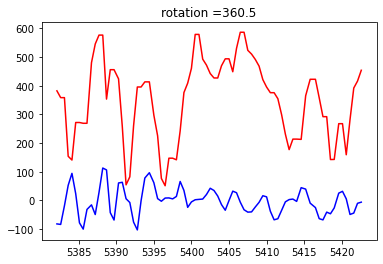

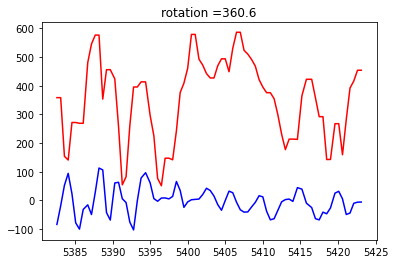

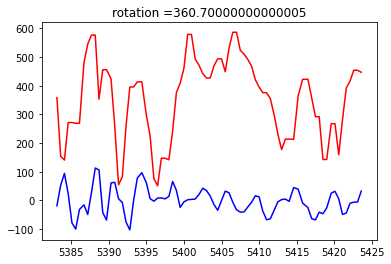

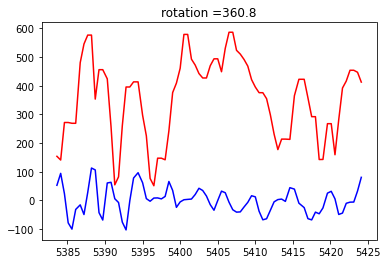

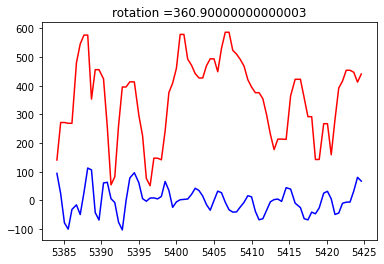

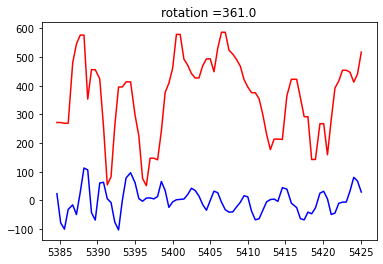

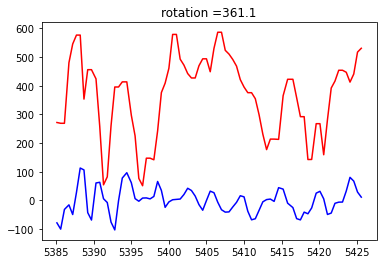

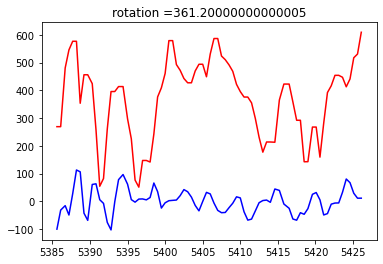

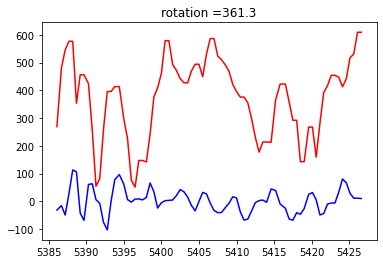

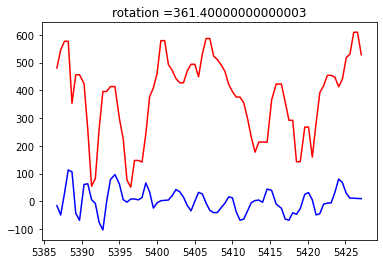

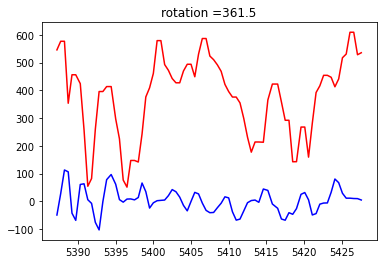

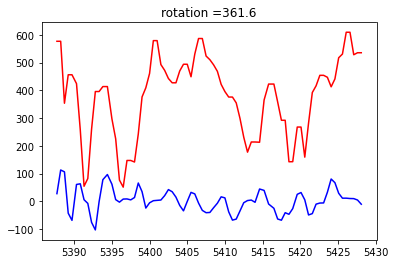

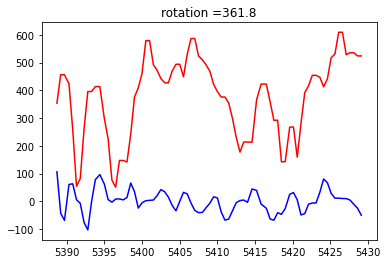

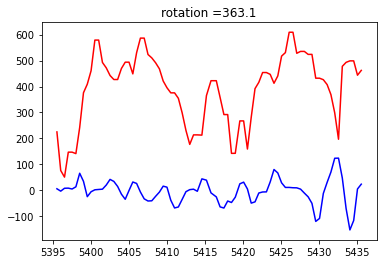

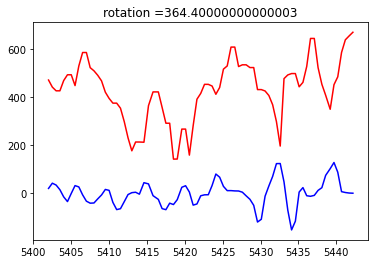

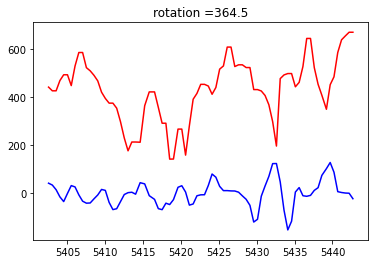

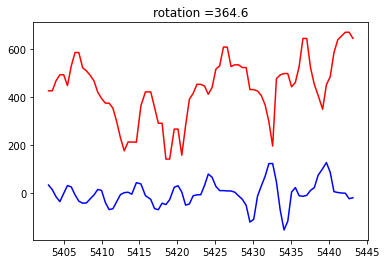

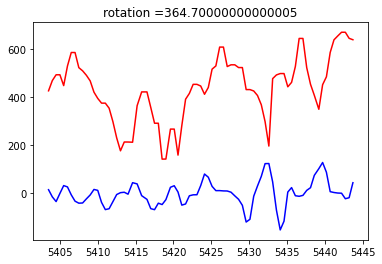

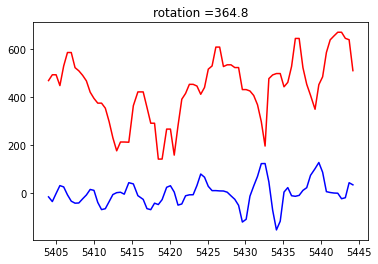

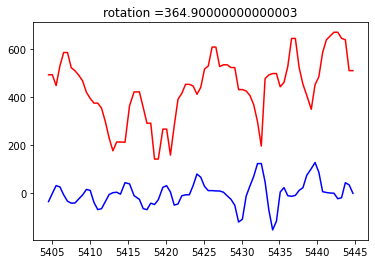

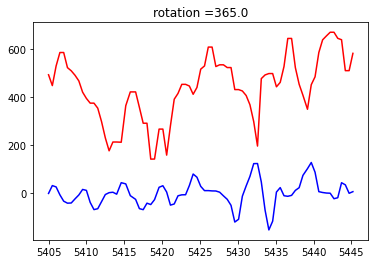

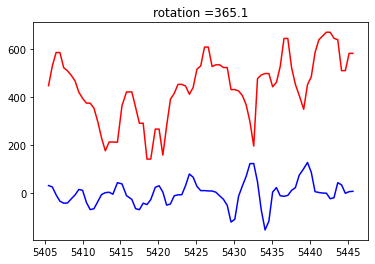

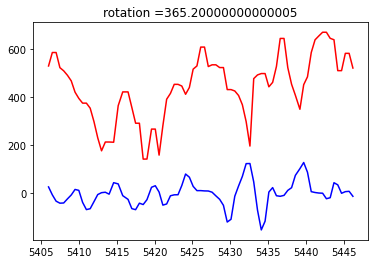

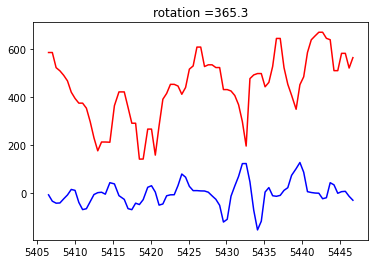

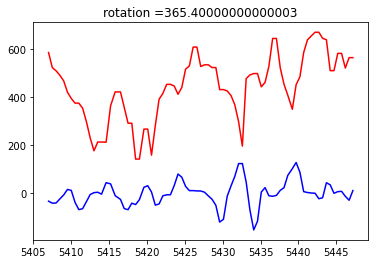

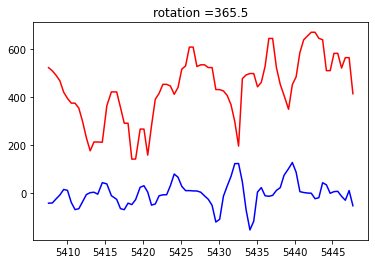

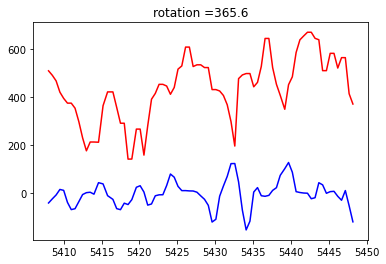

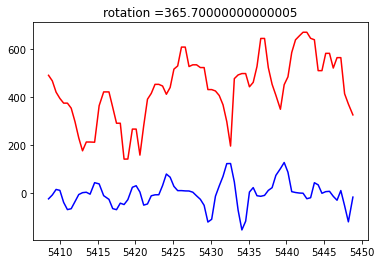

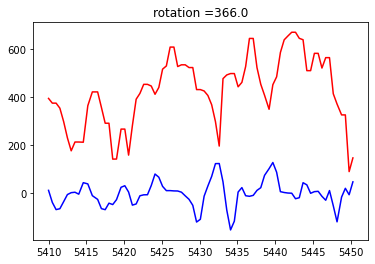

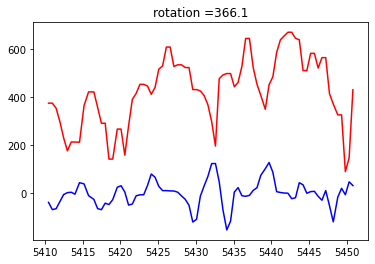

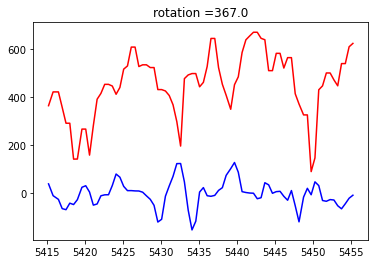

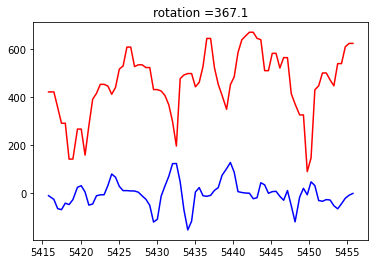

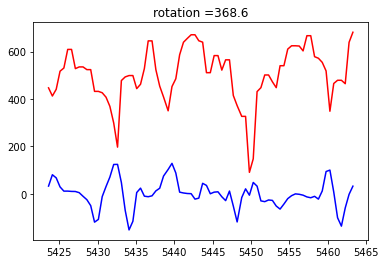

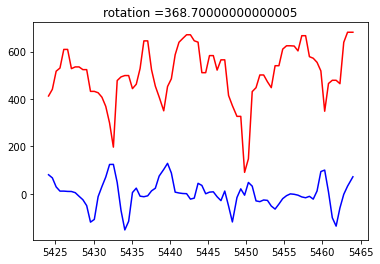

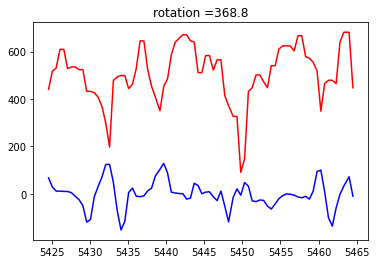

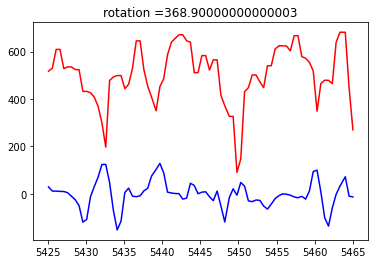

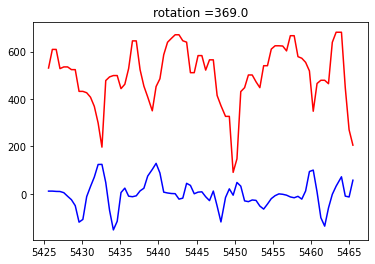

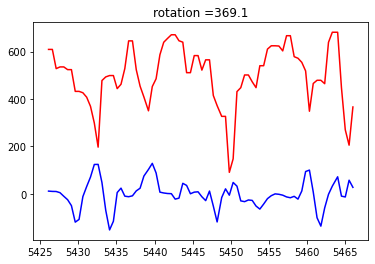

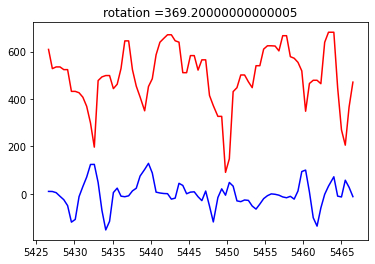

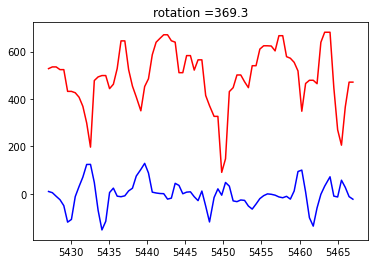

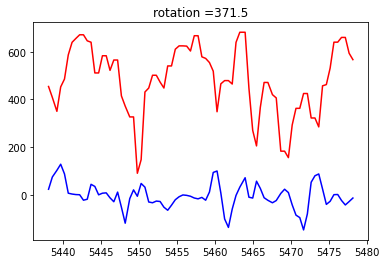

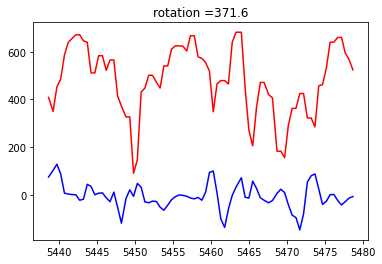

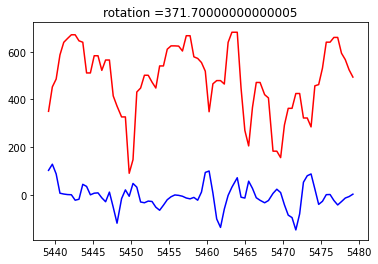

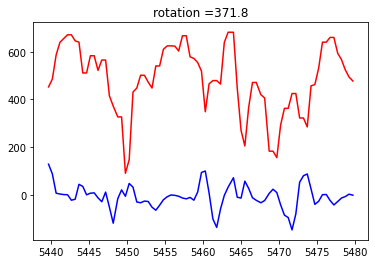

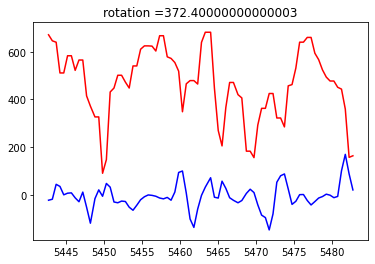

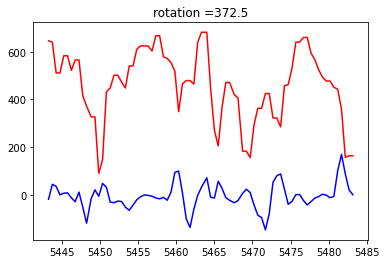

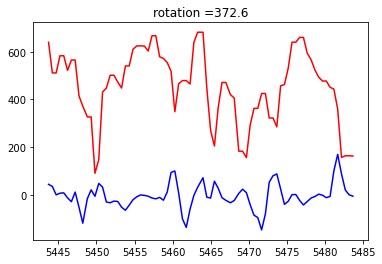

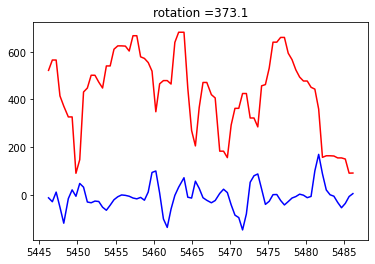

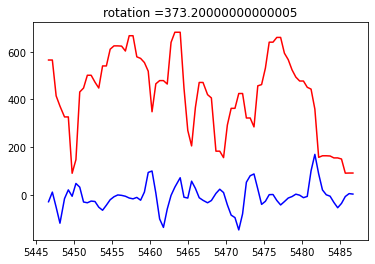

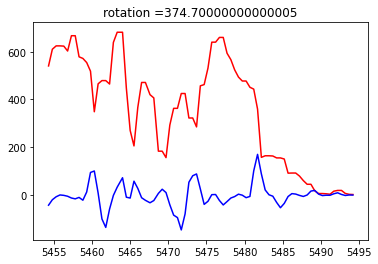

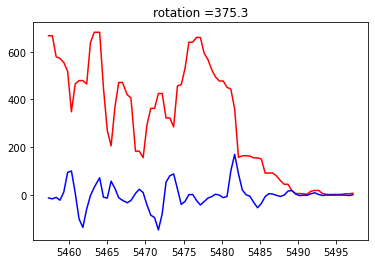

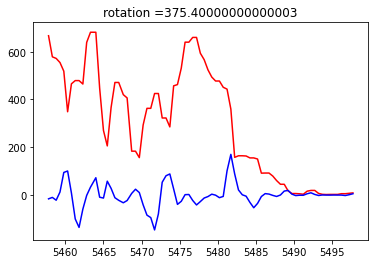

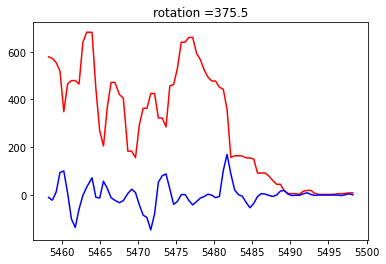

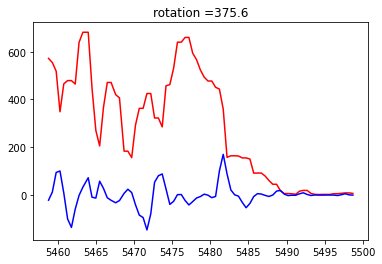

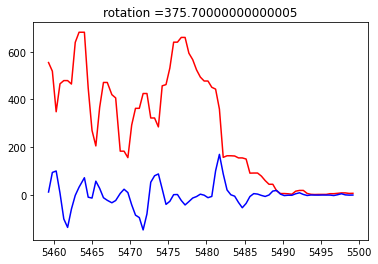

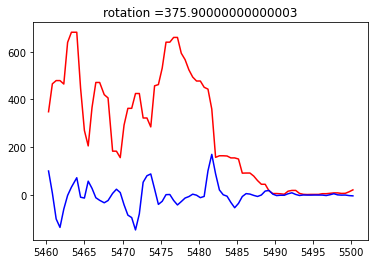

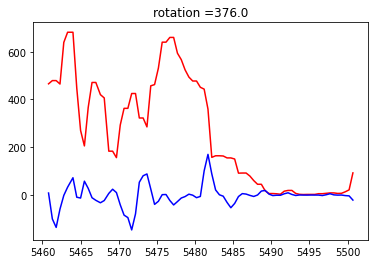

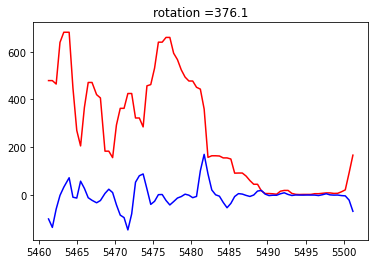

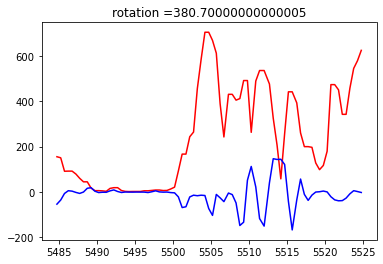

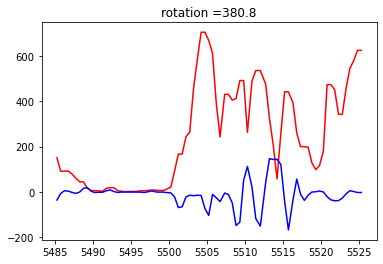

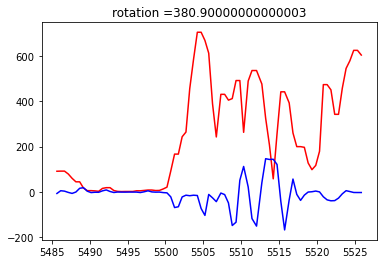

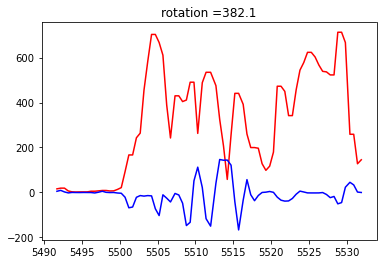

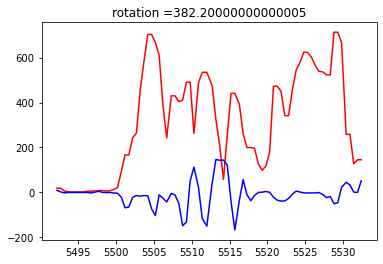

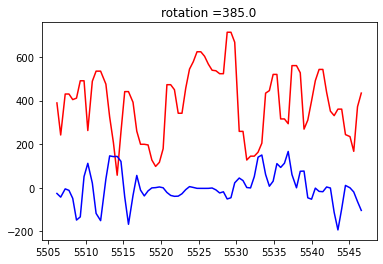

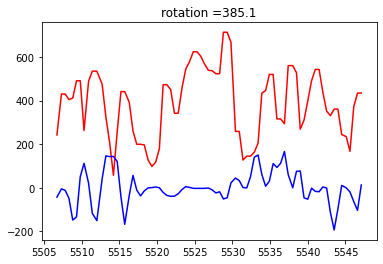

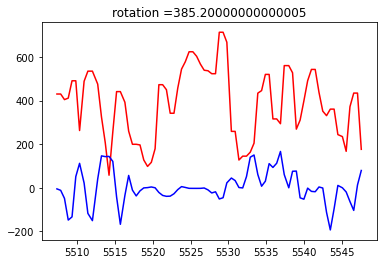

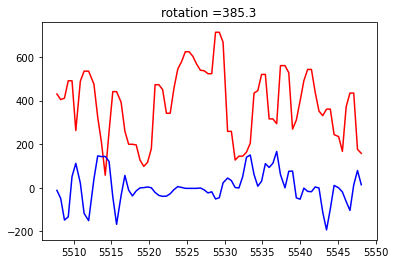

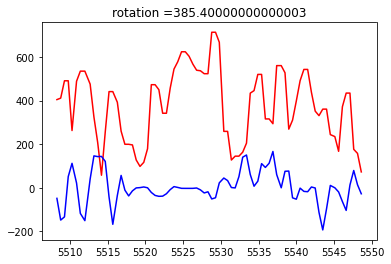

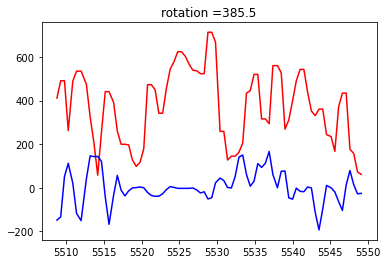

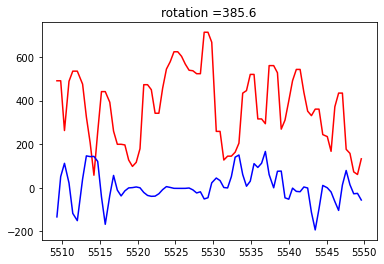

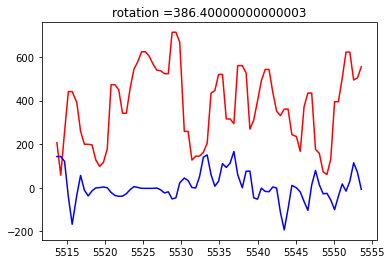

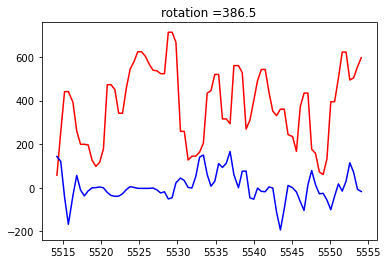

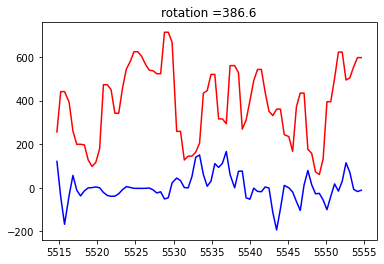

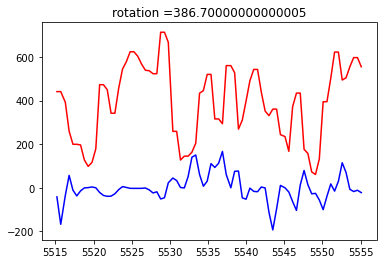

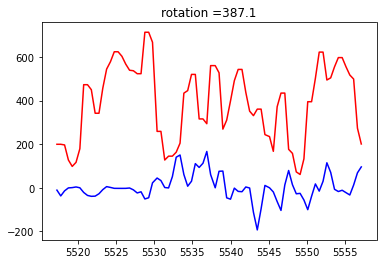

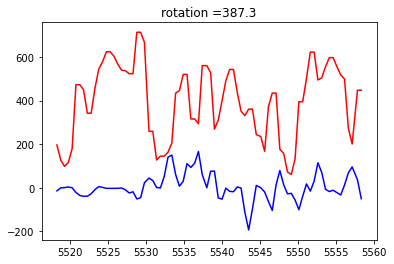

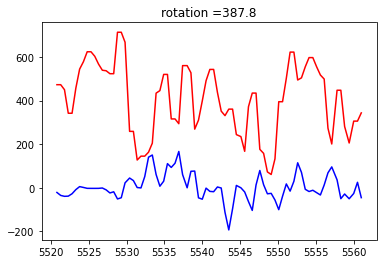

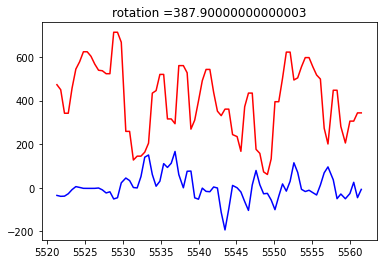

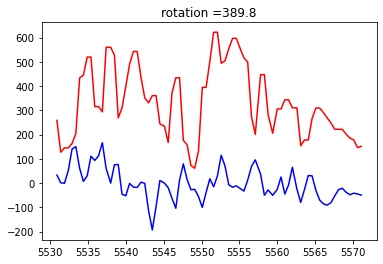

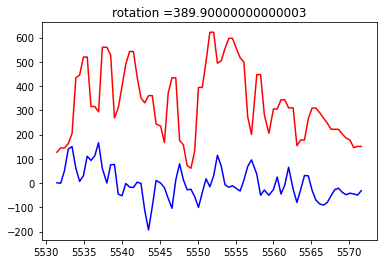

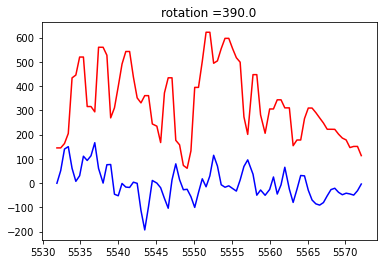

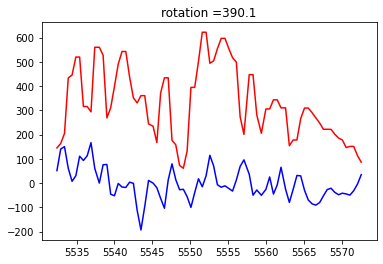

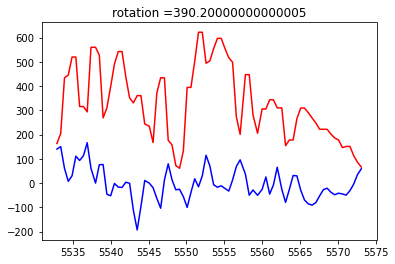

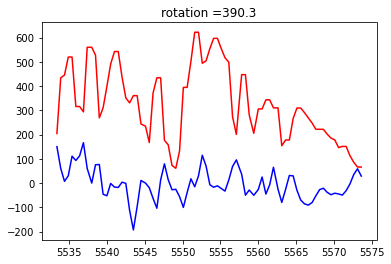

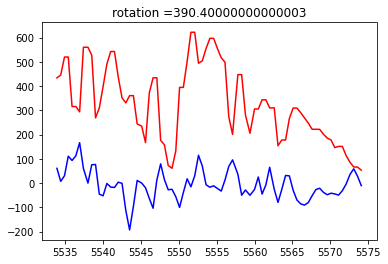

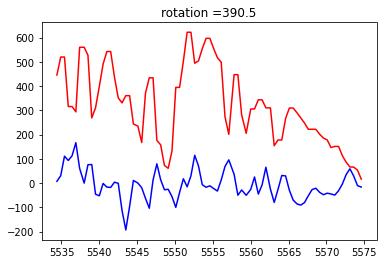

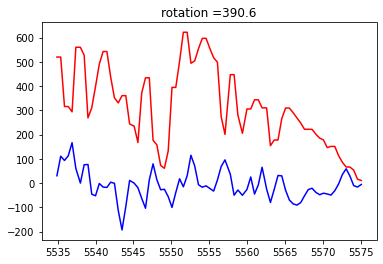

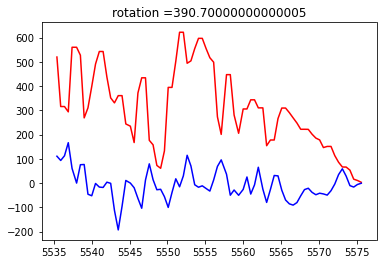

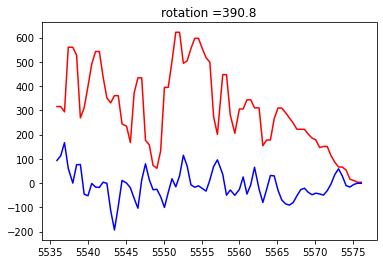

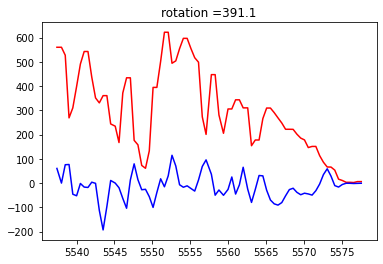

In [132]:
#for i in Sprint:
random_array = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in range(0,len(Sprint),1):
    plotfaults(Sprint[i], df.wheelRotationalSpeedX.to_numpy(), df.frameRotationalSpeedZ.to_numpy(), df.timeLine.to_numpy())

SyntaxError: invalid syntax (1373106854.py, line 1)

=top - 13:21:20 up 21 days, 19:44,  2 users,  load average: 109.15, 482.52, 358.1
Tasks: 1582 total,   2 running, 1315 sleeping,   0 stopped,   3 zombie
%Cpu(s):  6.6 us,  1.7 sy,  0.0 ni, 91.6 id,  0.1 wa,  0.0 hi,  0.0 si,  0.0 st
KiB Mem : 13170094+total,  8622888 free, 12042632+used,  2651736 buff/cache
KiB Swap:  2097148 total,     5404 free,  2091744 used. 10204784 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
14777 21084424  20   0 6771912 505876  30820 R 376.2  0.4  34:46.62 python      
21039 19143451  20   0 11.974g 417348  28308 S 247.6  0.3   0:09.86 java        
21302 19072074  20   0   43344   5396   3200 R  28.6  0.0   0:00.10 top         
43601 20170637  20   0 12.040g 262408   8428 S   9.5  0.2   2:01.94 java        
  132 root      20   0       0      0      0 S   4.8  0.0   0:16.13 ksoftirqd/+ 
 2236 tryton    20   0  190456   1688      0 S   4.8  0.0   5:41.44 trytond     
 9691 20189176  20   0 15.714g 498284  18632 S